In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.3/107.7 GB disk)


In [ ]:
%pip install opencv-python
import cv2
print(cv2.__version__)
%pip install ffmpeg-python

4.7.0


In [ ]:
from datetime import timedelta
#import cv2
import ffmpeg
from google.colab.patches import cv2_imshow
import numpy as np
import os
import yaml
import datetime
import torch
import warnings
import glob
import sys
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sn
from ultralytics import YOLO
from moviepy.editor import VideoFileClip

In [ ]:
#кадры в секунду
SAVING_FRAMES_PER_SECOND = 2

In [ ]:
#Служебная функция для классного форматирования объектов timedelta
#исключая микросекунды и сохраняя миллисекунды
def format_timedelta(td):
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")

#Функция, которая возвращает список длительностей, в которые следует сохранять кадры.
def get_saving_frames_durations(cap, saving_fps):
    s = []
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

In [ ]:
# Load a model
#model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
#model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True, device='cpu')

100%|██████████| 6.23M/6.23M [00:00<00:00, 39.6MB/s]


In [ ]:
#переписанный код
#если log=True печатает время в видео которому соответсвует кадр
def detect(video_file, color = (0, 0, 255,255), vmax = 125, vmin = 0, log = False):
    frame_to_draw = None#рамка для рисования
    f = True
    global filename
    filename, _ = os.path.splitext(video_file)#filename-содержит имя файла(расширение файла удаляется)
    filename += "-results"#добавляется -result в имени файла

    if not os.path.isdir(filename):#если filename не каталог или не сущетсвует
        os.mkdir(filename)#создаем каталог filename
    cap = cv2.VideoCapture(video_file)#захватываем исходное видео

    if not(cap.isOpened()):
      print("Формат не поддерживается")
      return
    fps = cap.get(cv2.CAP_PROP_FPS)#кадры в секунду у видео

    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)# сохранение кадров в секунду мин(2, fps)
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)#длительность кадров
    count = 0
    layer = 0
    map_data = []
    while True:
        is_read, frame = cap.read()#is_read=True/False если frame прочитан коректно
        if not is_read:
          #если нет кадров выходим
            break
        frame_duration = count / fps#продолжительность кадра
        try:
            closest_duration = saving_frames_durations[0]#первая продолжительность
        except IndexError:
          #все продолжительности сохранены
            break
        if frame_duration >= closest_duration:
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            path = filename+'/'+f"frame{frame_duration_formatted}.jpg";
            if(f == True):
              #все действия делаются один раз
              frame_to_draw = frame.copy()#кадр для рисовани- это первый кадр
              frame_to_draw=cv2.cvtColor(frame_to_draw, cv2.COLOR_BGR2BGRA)#перевод из 3-х канального в 4-х канальное
              height, width, channels = frame_to_draw.shape#высота, ширина и каналы
              white_picture=np.ones((height,width,4), dtype=np.uint8)*255#белый фон
              #заполнение нулями mad_data
              map_data = [0]*int(width)
              for i in range(0, int(width)):
                map_data[i] = [0]*int(height)
              f = False
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass

            #работа с моделью
            results = model.predict(frame)
            result=results[0]#список всех обнаруженных объектов
            box_for_human=[]#список боксов людей на кадре
            for box in result.boxes:
              if (box.cls[0]==0):#если id бокса равен 0(person), то добавляем его в список
                if(round(box.conf[0].item(), 2)*100 >40):#сравнение коэффициента уверенности в том что это человек
                  box_for_human.append(box)
            if(len(box_for_human)>0):
              if(log):
                print('Количество людей на кадре: ' + str(len(box_for_human)))

              for box in box_for_human:
              #для каждого бокса в листе боксов людей
              #мы сохраняем в переменные координаты x1y1x2y2
              #добавляем в map_data единицу за каждый пиксель попавший в прямоугльник на вершинах x1y1x2y2
                box_list=box.xyxy.tolist()#список координатов бокса
                xmin,ymin,xmax,ymax=tuple(map(int,box_list[0]))
                for j in range(xmin, xmax):
                  for k in range(ymin, ymax):
                    if(map_data[j][k] >= vmin):
                      if(map_data[j][k] < vmax):
                        map_data[j][k] = map_data[j][k] + 1

                tmp=frame_to_draw.copy()#Временное изображение, на котором мы рисуем прямоугльник
                tmp1=white_picture.copy()
                alpha=0.015#для frame_to_draw
                alpha1=0.99#для white_picture
                cv2.rectangle(tmp, (xmin,ymin), (xmax,ymax),color,-1)
                cv2.rectangle(white_picture, (xmin, ymin),(xmax,ymax), color, -1)
                frame_to_draw=cv2.addWeighted(tmp,alpha, frame_to_draw, 1-alpha,0)
                white_picture=cv2.addWeighted(tmp1,alpha1, white_picture, 1-alpha1,0)
              if(log):
                print(f"frame: {frame_duration_formatted}")
        count += 1#переход к следюющему кадру

    #конец цикла------------------------------------------------------------------------------------------------
    cv2.imwrite(os.path.join(filename, f"result.png"), frame_to_draw)
    cv2.imwrite(os.path.join(filename, f"result-white.png"), white_picture)
    cv2_imshow(frame_to_draw)
    cv2_imshow(white_picture)
    map_data = np.fliplr(map_data)
    map_data = np.rot90(map_data)
    return np.array(map_data)



0: 384x640 12 persons, 330.8ms
Speed: 19.1ms preprocess, 330.8ms inference, 32.9ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0:00:00.00



0: 384x640 14 persons, 140.4ms
Speed: 5.3ms preprocess, 140.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-00.52



0: 384x640 11 persons, 151.1ms
Speed: 3.6ms preprocess, 151.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-01.04


0: 384x640 9 persons, 1 backpack, 141.5ms
Speed: 3.8ms preprocess, 141.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-00-01.52


0: 384x640 9 persons, 151.6ms
Speed: 5.0ms preprocess, 151.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-02.04


0: 384x640 9 persons, 144.1ms
Speed: 5.1ms preprocess, 144.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-00-02.52


0: 384x640 11 persons, 145.4ms
Speed: 3.5ms preprocess, 145.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-03.04


0: 384x640 10 persons, 1 backpack, 158.1ms
Speed: 3.5ms preprocess, 158.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-03.52


0: 384x640 9 persons, 149.8ms
Speed: 7.9ms preprocess, 149.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-00-04.04


0: 384x640 10 persons, 141.0ms
Speed: 8.8ms preprocess, 141.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-04.52



0: 384x640 10 persons, 137.1ms
Speed: 3.8ms preprocess, 137.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-00-05.04


0: 384x640 10 persons, 1 backpack, 140.3ms
Speed: 3.9ms preprocess, 140.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-05.52



0: 384x640 8 persons, 134.8ms
Speed: 4.0ms preprocess, 134.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-06.04



0: 384x640 10 persons, 141.0ms
Speed: 3.1ms preprocess, 141.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-00-06.52


0: 384x640 9 persons, 1 backpack, 147.1ms
Speed: 3.5ms preprocess, 147.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-07.04


0: 384x640 9 persons, 1 car, 143.5ms
Speed: 3.2ms preprocess, 143.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-00-07.52



0: 384x640 10 persons, 132.4ms
Speed: 4.8ms preprocess, 132.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-00-08.04


0: 384x640 13 persons, 1 backpack, 138.4ms
Speed: 3.2ms preprocess, 138.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-08.52


0: 384x640 13 persons, 145.3ms
Speed: 4.3ms preprocess, 145.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-00-09.04


0: 384x640 15 persons, 200.2ms
Speed: 9.0ms preprocess, 200.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-00-09.52



0: 384x640 12 persons, 1 backpack, 223.6ms
Speed: 10.9ms preprocess, 223.6ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-00-10.04



0: 384x640 10 persons, 355.0ms
Speed: 10.2ms preprocess, 355.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-10.52



0: 384x640 11 persons, 1 cow, 242.1ms
Speed: 5.5ms preprocess, 242.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-11.04



0: 384x640 11 persons, 1 bird, 236.3ms
Speed: 11.3ms preprocess, 236.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-00-11.52



0: 384x640 10 persons, 2 horses, 213.7ms
Speed: 4.9ms preprocess, 213.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-00-12.04



0: 384x640 10 persons, 219.3ms
Speed: 3.6ms preprocess, 219.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-12.52



0: 384x640 11 persons, 1 dog, 223.9ms
Speed: 3.6ms preprocess, 223.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-13.04



0: 384x640 16 persons, 213.2ms
Speed: 3.7ms preprocess, 213.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-13.52



0: 384x640 13 persons, 222.6ms
Speed: 4.2ms preprocess, 222.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-14.04



0: 384x640 10 persons, 137.4ms
Speed: 4.8ms preprocess, 137.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-14.52



0: 384x640 8 persons, 158.5ms
Speed: 4.8ms preprocess, 158.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-15.04



0: 384x640 13 persons, 141.5ms
Speed: 5.7ms preprocess, 141.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-00-15.52



0: 384x640 11 persons, 141.0ms
Speed: 7.1ms preprocess, 141.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-00-16.04



0: 384x640 13 persons, 144.8ms
Speed: 3.8ms preprocess, 144.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-16.52



0: 384x640 12 persons, 139.8ms
Speed: 3.3ms preprocess, 139.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-00-17.04


0: 384x640 15 persons, 146.4ms
Speed: 6.3ms preprocess, 146.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-17.52



0: 384x640 10 persons, 132.7ms
Speed: 3.5ms preprocess, 132.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-18.04


0: 384x640 15 persons, 140.2ms
Speed: 3.3ms preprocess, 140.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-18.52



0: 384x640 12 persons, 145.1ms
Speed: 6.9ms preprocess, 145.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-00-19.04


0: 384x640 12 persons, 147.8ms
Speed: 3.5ms preprocess, 147.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-19.52



0: 384x640 8 persons, 200.3ms
Speed: 3.9ms preprocess, 200.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 3
frame: 0-00-20.04



0: 384x640 11 persons, 180.7ms
Speed: 7.9ms preprocess, 180.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-00-20.52



0: 384x640 13 persons, 170.7ms
Speed: 6.6ms preprocess, 170.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-21.04



0: 384x640 11 persons, 189.7ms
Speed: 6.0ms preprocess, 189.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-21.52



0: 384x640 13 persons, 127.3ms
Speed: 3.9ms preprocess, 127.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-00-22.04


0: 384x640 14 persons, 153.8ms
Speed: 3.7ms preprocess, 153.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-22.52



0: 384x640 13 persons, 1 cow, 138.4ms
Speed: 2.8ms preprocess, 138.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-00-23.04


0: 384x640 15 persons, 143.8ms
Speed: 3.8ms preprocess, 143.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-23.52



0: 384x640 8 persons, 1 motorcycle, 148.1ms
Speed: 5.0ms preprocess, 148.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-00-24.04


0: 384x640 12 persons, 137.6ms
Speed: 3.4ms preprocess, 137.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-00-24.52


0: 384x640 9 persons, 135.2ms
Speed: 4.5ms preprocess, 135.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-25.04



0: 384x640 9 persons, 140.1ms
Speed: 4.0ms preprocess, 140.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-00-25.52



0: 384x640 13 persons, 144.6ms
Speed: 3.5ms preprocess, 144.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-00-26.04



0: 384x640 11 persons, 152.8ms
Speed: 7.3ms preprocess, 152.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-26.52



0: 384x640 9 persons, 140.7ms
Speed: 3.3ms preprocess, 140.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-27.04



0: 384x640 12 persons, 220.5ms
Speed: 3.7ms preprocess, 220.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-27.52



0: 384x640 13 persons, 216.8ms
Speed: 3.5ms preprocess, 216.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-28.04



0: 384x640 13 persons, 217.8ms
Speed: 3.6ms preprocess, 217.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-28.52



0: 384x640 13 persons, 238.9ms
Speed: 3.6ms preprocess, 238.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-29.04



0: 384x640 12 persons, 259.4ms
Speed: 3.7ms preprocess, 259.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-00-29.52



0: 384x640 13 persons, 231.8ms
Speed: 3.8ms preprocess, 231.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-00-30.04



0: 384x640 13 persons, 235.0ms
Speed: 6.5ms preprocess, 235.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-30.52



0: 384x640 11 persons, 217.3ms
Speed: 3.6ms preprocess, 217.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-31.04



0: 384x640 12 persons, 143.3ms
Speed: 3.8ms preprocess, 143.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-00-31.52



0: 384x640 13 persons, 139.3ms
Speed: 3.6ms preprocess, 139.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-00-32.04



0: 384x640 12 persons, 149.9ms
Speed: 4.1ms preprocess, 149.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-32.52



0: 384x640 13 persons, 140.9ms
Speed: 3.1ms preprocess, 140.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-33.04



0: 384x640 11 persons, 139.4ms
Speed: 4.2ms preprocess, 139.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-33.52



0: 384x640 11 persons, 1 motorcycle, 141.3ms
Speed: 3.5ms preprocess, 141.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-34.04



0: 384x640 13 persons, 142.5ms
Speed: 3.1ms preprocess, 142.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-34.52



0: 384x640 11 persons, 152.8ms
Speed: 3.9ms preprocess, 152.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-35.04



0: 384x640 11 persons, 137.8ms
Speed: 3.8ms preprocess, 137.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-35.52



0: 384x640 11 persons, 142.3ms
Speed: 3.8ms preprocess, 142.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-36.04



0: 384x640 9 persons, 149.2ms
Speed: 5.7ms preprocess, 149.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-36.52



0: 384x640 12 persons, 131.5ms
Speed: 2.9ms preprocess, 131.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-37.04



0: 384x640 11 persons, 131.4ms
Speed: 3.7ms preprocess, 131.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-37.52



0: 384x640 12 persons, 133.2ms
Speed: 3.7ms preprocess, 133.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-38.04



0: 384x640 16 persons, 140.3ms
Speed: 3.5ms preprocess, 140.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-00-38.52



0: 384x640 13 persons, 133.2ms
Speed: 5.4ms preprocess, 133.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-00-39.04


0: 384x640 9 persons, 1 boat, 144.8ms
Speed: 3.7ms preprocess, 144.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-39.52



0: 384x640 9 persons, 134.8ms
Speed: 3.4ms preprocess, 134.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-00-40.04


0: 384x640 8 persons, 141.9ms
Speed: 3.5ms preprocess, 141.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-40.52



0: 384x640 11 persons, 132.2ms
Speed: 4.0ms preprocess, 132.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 9
frame: 0-00-41.04


0: 384x640 12 persons, 144.0ms
Speed: 4.0ms preprocess, 144.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-41.52



0: 384x640 12 persons, 136.2ms
Speed: 3.0ms preprocess, 136.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 8
frame: 0-00-42.04


0: 384x640 11 persons, 1 horse, 131.3ms
Speed: 4.3ms preprocess, 131.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-42.52



0: 384x640 9 persons, 133.5ms
Speed: 2.6ms preprocess, 133.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 8
frame: 0-00-43.04


0: 384x640 10 persons, 145.6ms
Speed: 3.7ms preprocess, 145.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-43.52



0: 384x640 10 persons, 128.7ms
Speed: 3.8ms preprocess, 128.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-00-44.04


0: 384x640 10 persons, 132.9ms
Speed: 6.7ms preprocess, 132.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-00-44.52



0: 384x640 10 persons, 218.6ms
Speed: 3.5ms preprocess, 218.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-45.04



0: 384x640 14 persons, 231.0ms
Speed: 3.7ms preprocess, 231.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-45.52



0: 384x640 13 persons, 212.6ms
Speed: 4.6ms preprocess, 212.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-00-46.04



0: 384x640 12 persons, 211.5ms
Speed: 3.6ms preprocess, 211.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-46.52



0: 384x640 10 persons, 216.1ms
Speed: 3.7ms preprocess, 216.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-47.04



0: 384x640 12 persons, 215.1ms
Speed: 7.4ms preprocess, 215.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-47.52



0: 384x640 11 persons, 208.9ms
Speed: 3.7ms preprocess, 208.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-48.04



0: 384x640 10 persons, 220.5ms
Speed: 3.8ms preprocess, 220.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-48.52



0: 384x640 12 persons, 233.5ms
Speed: 3.6ms preprocess, 233.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-49.04



0: 384x640 11 persons, 145.2ms
Speed: 5.7ms preprocess, 145.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-00-49.52



0: 384x640 11 persons, 138.8ms
Speed: 4.6ms preprocess, 138.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-50.04



0: 384x640 13 persons, 1 motorcycle, 137.4ms
Speed: 4.1ms preprocess, 137.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-00-50.51



0: 384x640 8 persons, 1 motorcycle, 148.0ms
Speed: 5.2ms preprocess, 148.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-00-51.03


0: 384x640 10 persons, 1 motorcycle, 143.0ms
Speed: 6.1ms preprocess, 143.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-00-51.51



0: 384x640 11 persons, 134.5ms
Speed: 4.7ms preprocess, 134.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-00-52.03



0: 384x640 12 persons, 150.0ms
Speed: 5.7ms preprocess, 150.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-00-52.51



0: 384x640 12 persons, 136.9ms
Speed: 6.5ms preprocess, 136.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-00-53.03


0: 384x640 9 persons, 136.5ms
Speed: 3.4ms preprocess, 136.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-00-53.51


0: 384x640 10 persons, 135.0ms
Speed: 3.4ms preprocess, 135.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-00-54.03


0: 384x640 9 persons, 1 motorcycle, 143.8ms
Speed: 4.0ms preprocess, 143.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-00-54.51


0: 384x640 9 persons, 2 motorcycles, 146.4ms
Speed: 3.8ms preprocess, 146.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-00-55.03


0: 384x640 11 persons, 1 motorcycle, 137.8ms
Speed: 14.8ms preprocess, 137.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-55.51


0: 384x640 10 persons, 1 motorcycle, 144.5ms
Speed: 3.9ms preprocess, 144.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-00-56.03


0: 384x640 10 persons, 1 motorcycle, 136.9ms
Speed: 5.3ms preprocess, 136.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-00-56.51


0: 384x640 9 persons, 145.4ms
Speed: 3.4ms preprocess, 145.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-57.03


0: 384x640 8 persons, 1 motorcycle, 148.8ms
Speed: 7.2ms preprocess, 148.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-00-57.51


0: 384x640 8 persons, 148.4ms
Speed: 4.8ms preprocess, 148.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-58.03


0: 384x640 9 persons, 140.3ms
Speed: 5.8ms preprocess, 140.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-00-58.51


0: 384x640 7 persons, 143.2ms
Speed: 4.1ms preprocess, 143.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-00-59.03


0: 384x640 7 persons, 144.5ms
Speed: 4.1ms preprocess, 144.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-00-59.51



0: 384x640 6 persons, 144.6ms
Speed: 3.7ms preprocess, 144.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-01-00.03


0: 384x640 8 persons, 144.8ms
Speed: 5.1ms preprocess, 144.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-01-00.51


0: 384x640 5 persons, 147.0ms
Speed: 6.4ms preprocess, 147.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-01-01.03


0: 384x640 7 persons, 146.3ms
Speed: 3.9ms preprocess, 146.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-01.51



0: 384x640 10 persons, 133.9ms
Speed: 5.5ms preprocess, 133.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-02.03



0: 384x640 10 persons, 150.9ms
Speed: 3.9ms preprocess, 150.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-01-02.51



0: 384x640 8 persons, 180.8ms
Speed: 4.9ms preprocess, 180.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-03.03



0: 384x640 9 persons, 230.0ms
Speed: 3.9ms preprocess, 230.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-03.51



0: 384x640 8 persons, 217.3ms
Speed: 3.6ms preprocess, 217.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-04.03



0: 384x640 10 persons, 231.0ms
Speed: 4.0ms preprocess, 231.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-04.51



0: 384x640 10 persons, 221.2ms
Speed: 3.6ms preprocess, 221.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-05.03



0: 384x640 10 persons, 251.3ms
Speed: 6.2ms preprocess, 251.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-05.51



0: 384x640 13 persons, 235.8ms
Speed: 3.7ms preprocess, 235.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-01-06.03



0: 384x640 13 persons, 214.4ms
Speed: 3.6ms preprocess, 214.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-01-06.51



0: 384x640 10 persons, 222.7ms
Speed: 5.2ms preprocess, 222.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-07.03



0: 384x640 12 persons, 149.5ms
Speed: 8.7ms preprocess, 149.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-07.51



0: 384x640 13 persons, 154.3ms
Speed: 3.6ms preprocess, 154.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-01-08.03


0: 384x640 8 persons, 135.5ms
Speed: 7.4ms preprocess, 135.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-08.51



0: 384x640 9 persons, 136.9ms
Speed: 3.8ms preprocess, 136.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-09.03


0: 384x640 7 persons, 139.0ms
Speed: 5.1ms preprocess, 139.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-09.51


0: 384x640 8 persons, 1 horse, 160.9ms
Speed: 3.8ms preprocess, 160.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-01-10.03


0: 384x640 9 persons, 162.3ms
Speed: 3.8ms preprocess, 162.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-10.51



0: 384x640 12 persons, 143.6ms
Speed: 4.1ms preprocess, 143.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-01-11.03


0: 384x640 10 persons, 161.0ms
Speed: 4.8ms preprocess, 161.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-11.51



0: 384x640 10 persons, 147.0ms
Speed: 4.5ms preprocess, 147.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-12.03



0: 384x640 8 persons, 147.4ms
Speed: 3.5ms preprocess, 147.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-12.51



0: 384x640 10 persons, 136.6ms
Speed: 3.6ms preprocess, 136.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-13.03


0: 384x640 10 persons, 142.7ms
Speed: 2.8ms preprocess, 142.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-13.51



0: 384x640 10 persons, 134.1ms
Speed: 3.7ms preprocess, 134.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-14.03



0: 384x640 8 persons, 132.2ms
Speed: 6.3ms preprocess, 132.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-14.51



0: 384x640 11 persons, 1 motorcycle, 140.2ms
Speed: 3.9ms preprocess, 140.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-01-15.03


0: 384x640 10 persons, 165.9ms
Speed: 3.9ms preprocess, 165.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-15.51



0: 384x640 12 persons, 1 motorcycle, 139.6ms
Speed: 6.2ms preprocess, 139.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-16.03



0: 384x640 11 persons, 1 bench, 138.2ms
Speed: 3.9ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-16.51


0: 384x640 12 persons, 155.3ms
Speed: 12.6ms preprocess, 155.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-17.03


0: 384x640 11 persons, 1 motorcycle, 1 bench, 137.8ms
Speed: 6.4ms preprocess, 137.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-17.51



0: 384x640 11 persons, 1 motorcycle, 135.0ms
Speed: 4.7ms preprocess, 135.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-18.03



0: 384x640 9 persons, 1 motorcycle, 149.1ms
Speed: 4.6ms preprocess, 149.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-18.51


0: 384x640 9 persons, 2 motorcycles, 140.1ms
Speed: 14.6ms preprocess, 140.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-19.03


0: 384x640 10 persons, 1 motorcycle, 153.2ms
Speed: 3.5ms preprocess, 153.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-01-19.51


0: 384x640 9 persons, 1 motorcycle, 143.5ms
Speed: 4.5ms preprocess, 143.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-01-20.03


0: 384x640 8 persons, 1 motorcycle, 135.5ms
Speed: 5.4ms preprocess, 135.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-01-20.51


0: 384x640 9 persons, 164.5ms
Speed: 14.8ms preprocess, 164.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-21.03



0: 384x640 10 persons, 1 motorcycle, 231.6ms
Speed: 3.5ms preprocess, 231.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-21.51



0: 384x640 10 persons, 226.2ms
Speed: 3.7ms preprocess, 226.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-22.03



0: 384x640 10 persons, 227.3ms
Speed: 3.8ms preprocess, 227.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-22.51



0: 384x640 10 persons, 236.5ms
Speed: 4.3ms preprocess, 236.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-23.03



0: 384x640 12 persons, 226.3ms
Speed: 8.9ms preprocess, 226.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-01-23.51



0: 384x640 11 persons, 237.3ms
Speed: 3.7ms preprocess, 237.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-24.03



0: 384x640 8 persons, 219.5ms
Speed: 4.1ms preprocess, 219.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-24.51



0: 384x640 8 persons, 1 motorcycle, 234.5ms
Speed: 5.7ms preprocess, 234.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-25.03



0: 384x640 8 persons, 1 motorcycle, 145.7ms
Speed: 4.8ms preprocess, 145.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-25.51


0: 384x640 6 persons, 1 motorcycle, 1 frisbee, 144.3ms
Speed: 4.4ms preprocess, 144.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-26.03


0: 384x640 7 persons, 1 motorcycle, 138.4ms
Speed: 4.7ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-01-26.51


0: 384x640 9 persons, 1 motorcycle, 151.2ms
Speed: 6.0ms preprocess, 151.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-27.03



0: 384x640 9 persons, 1 motorcycle, 1 boat, 150.1ms
Speed: 6.0ms preprocess, 150.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-27.51



0: 384x640 11 persons, 1 motorcycle, 1 boat, 133.7ms
Speed: 4.7ms preprocess, 133.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-28.03



0: 384x640 11 persons, 1 motorcycle, 144.0ms
Speed: 6.4ms preprocess, 144.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-28.51


0: 384x640 12 persons, 1 motorcycle, 149.4ms
Speed: 5.0ms preprocess, 149.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 8
frame: 0-01-29.03


0: 384x640 11 persons, 1 motorcycle, 139.9ms
Speed: 10.6ms preprocess, 139.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-29.51



0: 384x640 11 persons, 1 motorcycle, 136.3ms
Speed: 4.3ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-30.03



0: 384x640 10 persons, 1 motorcycle, 138.0ms
Speed: 3.6ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-30.51



0: 384x640 10 persons, 1 motorcycle, 145.2ms
Speed: 3.8ms preprocess, 145.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 8
frame: 0-01-31.03


0: 384x640 8 persons, 1 motorcycle, 150.6ms
Speed: 7.3ms preprocess, 150.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-31.51



0: 384x640 10 persons, 2 motorcycles, 138.3ms
Speed: 3.5ms preprocess, 138.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-01-32.03



0: 384x640 10 persons, 2 motorcycles, 135.4ms
Speed: 3.7ms preprocess, 135.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-32.51



0: 384x640 10 persons, 1 motorcycle, 143.8ms
Speed: 3.8ms preprocess, 143.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-01-33.03


0: 384x640 9 persons, 3 motorcycles, 143.1ms
Speed: 10.1ms preprocess, 143.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-33.51



0: 384x640 10 persons, 2 motorcycles, 135.4ms
Speed: 4.1ms preprocess, 135.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-34.03


0: 384x640 9 persons, 1 motorcycle, 139.4ms
Speed: 6.7ms preprocess, 139.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-34.51


0: 384x640 10 persons, 1 motorcycle, 152.4ms
Speed: 6.7ms preprocess, 152.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-35.03


0: 384x640 8 persons, 1 motorcycle, 153.7ms
Speed: 4.6ms preprocess, 153.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-35.51



0: 384x640 8 persons, 1 motorcycle, 127.6ms
Speed: 4.8ms preprocess, 127.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-01-36.03


0: 384x640 10 persons, 133.6ms
Speed: 3.7ms preprocess, 133.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-36.51


0: 384x640 10 persons, 1 motorcycle, 143.4ms
Speed: 5.3ms preprocess, 143.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-37.03



0: 384x640 9 persons, 1 motorcycle, 136.1ms
Speed: 5.5ms preprocess, 136.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-37.51



0: 384x640 9 persons, 237.8ms
Speed: 10.9ms preprocess, 237.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-38.03



0: 384x640 9 persons, 1 motorcycle, 348.5ms
Speed: 4.1ms preprocess, 348.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-38.51



0: 384x640 9 persons, 2 motorcycles, 767.0ms
Speed: 13.9ms preprocess, 767.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-39.03



0: 384x640 8 persons, 1 motorcycle, 503.1ms
Speed: 23.6ms preprocess, 503.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-39.51



0: 384x640 6 persons, 1 motorcycle, 603.0ms
Speed: 14.8ms preprocess, 603.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-40.03



0: 384x640 6 persons, 1 motorcycle, 632.4ms
Speed: 8.1ms preprocess, 632.4ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-40.51



0: 384x640 8 persons, 1 motorcycle, 337.3ms
Speed: 4.1ms preprocess, 337.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-41.03



0: 384x640 11 persons, 2 motorcycles, 272.0ms
Speed: 6.4ms preprocess, 272.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-41.51



0: 384x640 9 persons, 2 motorcycles, 454.6ms
Speed: 18.5ms preprocess, 454.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-42.03



0: 384x640 9 persons, 2 motorcycles, 218.6ms
Speed: 3.7ms preprocess, 218.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-42.51



0: 384x640 9 persons, 1 motorcycle, 228.5ms
Speed: 4.3ms preprocess, 228.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-43.03



0: 384x640 11 persons, 1 motorcycle, 291.0ms
Speed: 9.1ms preprocess, 291.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-01-43.51



0: 384x640 10 persons, 1 motorcycle, 1 boat, 305.7ms
Speed: 7.5ms preprocess, 305.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-44.03



0: 384x640 6 persons, 1 motorcycle, 2 horses, 213.8ms
Speed: 8.1ms preprocess, 213.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-01-44.51



0: 384x640 9 persons, 1 boat, 245.6ms
Speed: 5.6ms preprocess, 245.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-45.03



0: 384x640 8 persons, 235.4ms
Speed: 8.2ms preprocess, 235.4ms inference, 7.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-45.51



0: 384x640 9 persons, 2 horses, 210.5ms
Speed: 3.9ms preprocess, 210.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-46.03



0: 384x640 9 persons, 305.6ms
Speed: 5.8ms preprocess, 305.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-46.51



0: 384x640 9 persons, 2 motorcycles, 258.8ms
Speed: 3.7ms preprocess, 258.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-47.03



0: 384x640 9 persons, 2 motorcycles, 2 horses, 354.2ms
Speed: 3.7ms preprocess, 354.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-01-47.51



0: 384x640 13 persons, 3 motorcycles, 784.5ms
Speed: 12.2ms preprocess, 784.5ms inference, 7.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-48.03



0: 384x640 12 persons, 206.9ms
Speed: 3.5ms preprocess, 206.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-01-48.51



0: 384x640 13 persons, 224.7ms
Speed: 7.0ms preprocess, 224.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-49.03



0: 384x640 14 persons, 229.5ms
Speed: 3.6ms preprocess, 229.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-49.51



0: 384x640 10 persons, 215.9ms
Speed: 3.7ms preprocess, 215.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-50.03



0: 384x640 11 persons, 1 motorcycle, 213.1ms
Speed: 3.7ms preprocess, 213.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-01-50.51



0: 384x640 14 persons, 1 motorcycle, 227.8ms
Speed: 7.1ms preprocess, 227.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-51.03



0: 384x640 12 persons, 251.4ms
Speed: 7.9ms preprocess, 251.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-51.51



0: 384x640 13 persons, 136.7ms
Speed: 3.7ms preprocess, 136.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-01-52.03



0: 384x640 11 persons, 136.3ms
Speed: 3.6ms preprocess, 136.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-01-52.51



0: 384x640 9 persons, 1 motorcycle, 1 horse, 136.1ms
Speed: 3.7ms preprocess, 136.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-01-53.03


0: 384x640 10 persons, 1 motorcycle, 142.5ms
Speed: 3.3ms preprocess, 142.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-53.51



0: 384x640 12 persons, 144.1ms
Speed: 4.2ms preprocess, 144.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-54.03



0: 384x640 13 persons, 147.7ms
Speed: 3.9ms preprocess, 147.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-54.51



0: 384x640 11 persons, 148.9ms
Speed: 3.7ms preprocess, 148.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-01-55.03



0: 384x640 12 persons, 156.4ms
Speed: 4.2ms preprocess, 156.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-01-55.51



0: 384x640 13 persons, 135.9ms
Speed: 3.9ms preprocess, 135.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-01-56.03



0: 384x640 11 persons, 142.1ms
Speed: 5.7ms preprocess, 142.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-01-56.51



0: 384x640 11 persons, 137.7ms
Speed: 5.8ms preprocess, 137.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-57.03



0: 384x640 10 persons, 133.8ms
Speed: 3.8ms preprocess, 133.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-57.51



0: 384x640 10 persons, 1 horse, 136.3ms
Speed: 5.1ms preprocess, 136.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-58.03



0: 384x640 11 persons, 149.0ms
Speed: 3.6ms preprocess, 149.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-58.51



0: 384x640 11 persons, 143.8ms
Speed: 7.7ms preprocess, 143.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-01-59.03



0: 384x640 8 persons, 151.6ms
Speed: 7.7ms preprocess, 151.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-01-59.51



0: 384x640 10 persons, 2 motorcycles, 142.4ms
Speed: 3.9ms preprocess, 142.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-00.03



0: 384x640 10 persons, 2 motorcycles, 140.5ms
Speed: 4.3ms preprocess, 140.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-00.51



0: 384x640 7 persons, 1 motorcycle, 142.8ms
Speed: 5.0ms preprocess, 142.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-02-01.03


0: 384x640 8 persons, 3 motorcycles, 147.6ms
Speed: 3.5ms preprocess, 147.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-02-01.51


0: 384x640 8 persons, 4 motorcycles, 150.8ms
Speed: 4.0ms preprocess, 150.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-02-02.03


0: 384x640 9 persons, 5 motorcycles, 146.8ms
Speed: 4.9ms preprocess, 146.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-02-02.51


0: 384x640 9 persons, 3 motorcycles, 148.9ms
Speed: 4.1ms preprocess, 148.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-02-03.03


0: 384x640 9 persons, 3 motorcycles, 146.2ms
Speed: 5.6ms preprocess, 146.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-02-03.51



0: 384x640 11 persons, 2 motorcycles, 142.5ms
Speed: 5.3ms preprocess, 142.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-02-04.03



0: 384x640 10 persons, 5 motorcycles, 144.5ms
Speed: 3.8ms preprocess, 144.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-02-04.51



0: 384x640 11 persons, 2 motorcycles, 193.5ms
Speed: 3.6ms preprocess, 193.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-02-05.03



0: 384x640 10 persons, 244.9ms
Speed: 3.7ms preprocess, 244.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-02-05.51



0: 384x640 8 persons, 1 motorcycle, 225.1ms
Speed: 3.8ms preprocess, 225.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-02-06.03



0: 384x640 10 persons, 1 car, 228.7ms
Speed: 6.4ms preprocess, 228.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-02-06.51



0: 384x640 12 persons, 1 car, 1 motorcycle, 227.6ms
Speed: 3.7ms preprocess, 227.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-02-07.03



0: 384x640 10 persons, 235.7ms
Speed: 3.5ms preprocess, 235.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-02-07.51



0: 384x640 12 persons, 233.3ms
Speed: 3.8ms preprocess, 233.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-02-08.03



0: 384x640 14 persons, 1 boat, 225.9ms
Speed: 3.9ms preprocess, 225.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-08.51



0: 384x640 11 persons, 243.1ms
Speed: 6.5ms preprocess, 243.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-09.03



0: 384x640 12 persons, 1 boat, 1 bench, 154.4ms
Speed: 3.9ms preprocess, 154.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-02-09.51



0: 384x640 14 persons, 1 boat, 1 bench, 138.4ms
Speed: 3.6ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-02-10.03


0: 384x640 10 persons, 1 motorcycle, 1 bench, 146.1ms
Speed: 5.7ms preprocess, 146.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-02-10.51



0: 384x640 14 persons, 1 boat, 1 bench, 162.8ms
Speed: 3.8ms preprocess, 162.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-02-11.03


0: 384x640 12 persons, 1 bench, 161.9ms
Speed: 3.8ms preprocess, 161.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-11.51



0: 384x640 12 persons, 1 bench, 136.4ms
Speed: 4.8ms preprocess, 136.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-12.03



0: 384x640 10 persons, 1 bench, 141.7ms
Speed: 4.2ms preprocess, 141.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-12.51



0: 384x640 9 persons, 1 boat, 1 bench, 140.3ms
Speed: 5.5ms preprocess, 140.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-13.03



0: 384x640 9 persons, 1 bench, 139.3ms
Speed: 3.7ms preprocess, 139.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-02-13.51



0: 384x640 11 persons, 1 boat, 1 bench, 142.8ms
Speed: 4.1ms preprocess, 142.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-14.03



0: 384x640 14 persons, 1 boat, 1 bench, 142.9ms
Speed: 8.5ms preprocess, 142.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-14.51



0: 384x640 13 persons, 1 boat, 1 bench, 144.8ms
Speed: 9.7ms preprocess, 144.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-15.03



0: 384x640 14 persons, 152.7ms
Speed: 5.3ms preprocess, 152.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-15.51



0: 384x640 15 persons, 141.6ms
Speed: 3.7ms preprocess, 141.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-16.03



0: 384x640 14 persons, 147.3ms
Speed: 4.8ms preprocess, 147.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-16.51



0: 384x640 14 persons, 143.7ms
Speed: 8.0ms preprocess, 143.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-17.03



0: 384x640 11 persons, 147.0ms
Speed: 4.4ms preprocess, 147.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-17.51



0: 384x640 12 persons, 141.4ms
Speed: 4.6ms preprocess, 141.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-18.03



0: 384x640 11 persons, 140.0ms
Speed: 3.8ms preprocess, 140.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-18.51



0: 384x640 11 persons, 153.3ms
Speed: 3.4ms preprocess, 153.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-19.03



0: 384x640 13 persons, 144.1ms
Speed: 3.9ms preprocess, 144.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-19.51



0: 384x640 14 persons, 148.5ms
Speed: 4.7ms preprocess, 148.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-20.03



0: 384x640 15 persons, 132.5ms
Speed: 3.9ms preprocess, 132.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-20.51



0: 384x640 11 persons, 139.6ms
Speed: 7.2ms preprocess, 139.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-21.03



0: 384x640 15 persons, 136.2ms
Speed: 3.7ms preprocess, 136.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-21.51



0: 384x640 16 persons, 176.2ms
Speed: 5.5ms preprocess, 176.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-22.03



0: 384x640 16 persons, 1 bench, 227.5ms
Speed: 3.4ms preprocess, 227.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-22.51



0: 384x640 14 persons, 2 benchs, 230.4ms
Speed: 3.6ms preprocess, 230.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-23.03



0: 384x640 16 persons, 1 boat, 1 bench, 222.1ms
Speed: 3.6ms preprocess, 222.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-23.51



0: 384x640 19 persons, 1 bench, 235.6ms
Speed: 3.7ms preprocess, 235.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-24.03



0: 384x640 12 persons, 232.8ms
Speed: 3.4ms preprocess, 232.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-24.51



0: 384x640 14 persons, 230.3ms
Speed: 3.8ms preprocess, 230.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-25.03



0: 384x640 15 persons, 224.3ms
Speed: 3.4ms preprocess, 224.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-25.51



0: 384x640 13 persons, 1 boat, 233.6ms
Speed: 3.9ms preprocess, 233.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-26.03



0: 384x640 14 persons, 1 boat, 1 bench, 132.9ms
Speed: 3.9ms preprocess, 132.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-26.51



0: 384x640 15 persons, 139.8ms
Speed: 4.5ms preprocess, 139.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-27.03



0: 384x640 13 persons, 133.2ms
Speed: 3.9ms preprocess, 133.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-27.51



0: 384x640 13 persons, 143.2ms
Speed: 11.2ms preprocess, 143.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-28.03



0: 384x640 14 persons, 138.1ms
Speed: 3.7ms preprocess, 138.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-28.51



0: 384x640 14 persons, 1 boat, 144.8ms
Speed: 3.8ms preprocess, 144.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-29.03



0: 384x640 17 persons, 1 boat, 143.7ms
Speed: 4.0ms preprocess, 143.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-02-29.51



0: 384x640 16 persons, 140.9ms
Speed: 3.4ms preprocess, 140.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-30.03



0: 384x640 14 persons, 150.4ms
Speed: 3.8ms preprocess, 150.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-30.51



0: 384x640 12 persons, 142.6ms
Speed: 9.2ms preprocess, 142.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-31.03



0: 384x640 12 persons, 155.1ms
Speed: 4.3ms preprocess, 155.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-31.50



0: 384x640 17 persons, 134.9ms
Speed: 4.0ms preprocess, 134.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-02-32.02



0: 384x640 14 persons, 145.0ms
Speed: 4.0ms preprocess, 145.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-32.50



0: 384x640 12 persons, 1 motorcycle, 134.8ms
Speed: 3.9ms preprocess, 134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-33.02



0: 384x640 12 persons, 137.0ms
Speed: 5.7ms preprocess, 137.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-33.50



0: 384x640 11 persons, 1 motorcycle, 150.2ms
Speed: 6.6ms preprocess, 150.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-02-34.02



0: 384x640 12 persons, 1 bench, 138.2ms
Speed: 3.6ms preprocess, 138.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-34.50



0: 384x640 12 persons, 1 bench, 133.9ms
Speed: 9.9ms preprocess, 133.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-35.02



0: 384x640 15 persons, 134.9ms
Speed: 3.7ms preprocess, 134.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-35.50



0: 384x640 16 persons, 141.9ms
Speed: 6.0ms preprocess, 141.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-36.02



0: 384x640 16 persons, 157.6ms
Speed: 5.3ms preprocess, 157.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-36.50



0: 384x640 16 persons, 1 boat, 147.3ms
Speed: 7.3ms preprocess, 147.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-37.02



0: 384x640 15 persons, 142.8ms
Speed: 3.4ms preprocess, 142.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-02-37.50



0: 384x640 14 persons, 203.8ms
Speed: 3.9ms preprocess, 203.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-38.02



0: 384x640 13 persons, 256.9ms
Speed: 3.8ms preprocess, 256.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-02-38.50



0: 384x640 16 persons, 1 boat, 232.0ms
Speed: 4.9ms preprocess, 232.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-39.02



0: 384x640 15 persons, 1 boat, 231.0ms
Speed: 3.7ms preprocess, 231.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-39.50



0: 384x640 14 persons, 1 boat, 223.9ms
Speed: 3.7ms preprocess, 223.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-40.02



0: 384x640 13 persons, 1 boat, 215.9ms
Speed: 3.6ms preprocess, 215.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-40.50



0: 384x640 14 persons, 264.5ms
Speed: 3.6ms preprocess, 264.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-41.02



0: 384x640 15 persons, 238.5ms
Speed: 3.4ms preprocess, 238.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-41.50



0: 384x640 15 persons, 1 boat, 140.3ms
Speed: 4.0ms preprocess, 140.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-42.02



0: 384x640 15 persons, 1 boat, 145.5ms
Speed: 3.7ms preprocess, 145.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-02-42.50



0: 384x640 12 persons, 154.3ms
Speed: 4.5ms preprocess, 154.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-43.02



0: 384x640 18 persons, 142.5ms
Speed: 4.0ms preprocess, 142.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-43.50



0: 384x640 19 persons, 137.4ms
Speed: 3.6ms preprocess, 137.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-44.02



0: 384x640 17 persons, 141.3ms
Speed: 3.5ms preprocess, 141.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-02-44.50



0: 384x640 14 persons, 139.4ms
Speed: 6.1ms preprocess, 139.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-45.02



0: 384x640 15 persons, 141.6ms
Speed: 4.3ms preprocess, 141.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-45.50



0: 384x640 15 persons, 142.0ms
Speed: 5.3ms preprocess, 142.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-46.02



0: 384x640 17 persons, 146.9ms
Speed: 4.2ms preprocess, 146.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-46.50



0: 384x640 13 persons, 142.0ms
Speed: 3.2ms preprocess, 142.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-47.02



0: 384x640 11 persons, 140.0ms
Speed: 4.4ms preprocess, 140.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-47.50



0: 384x640 15 persons, 139.6ms
Speed: 4.1ms preprocess, 139.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-48.02



0: 384x640 15 persons, 139.3ms
Speed: 3.6ms preprocess, 139.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-48.50



0: 384x640 15 persons, 159.9ms
Speed: 12.0ms preprocess, 159.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-02-49.02



0: 384x640 17 persons, 153.6ms
Speed: 4.4ms preprocess, 153.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-49.50



0: 384x640 16 persons, 142.2ms
Speed: 4.0ms preprocess, 142.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-50.02



0: 384x640 14 persons, 138.2ms
Speed: 3.4ms preprocess, 138.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-50.50



0: 384x640 15 persons, 132.3ms
Speed: 5.2ms preprocess, 132.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-51.02



0: 384x640 16 persons, 161.6ms
Speed: 3.7ms preprocess, 161.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-51.50



0: 384x640 15 persons, 138.0ms
Speed: 3.7ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-52.02



0: 384x640 14 persons, 157.9ms
Speed: 5.3ms preprocess, 157.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-02-52.50



0: 384x640 13 persons, 1 boat, 138.2ms
Speed: 4.3ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-53.02



0: 384x640 12 persons, 1 boat, 155.4ms
Speed: 3.9ms preprocess, 155.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-53.50



0: 384x640 14 persons, 1 boat, 218.3ms
Speed: 7.4ms preprocess, 218.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-54.02



0: 384x640 12 persons, 1 boat, 219.5ms
Speed: 4.8ms preprocess, 219.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-54.50



0: 384x640 13 persons, 1 boat, 243.4ms
Speed: 3.8ms preprocess, 243.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-55.02



0: 384x640 11 persons, 1 boat, 246.1ms
Speed: 3.8ms preprocess, 246.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-55.50



0: 384x640 11 persons, 1 boat, 222.1ms
Speed: 3.7ms preprocess, 222.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-56.02



0: 384x640 13 persons, 1 boat, 240.6ms
Speed: 7.9ms preprocess, 240.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-56.50



0: 384x640 13 persons, 1 boat, 229.3ms
Speed: 3.7ms preprocess, 229.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-57.02



0: 384x640 12 persons, 1 boat, 222.3ms
Speed: 4.0ms preprocess, 222.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-02-57.50



0: 384x640 15 persons, 1 boat, 183.8ms
Speed: 4.5ms preprocess, 183.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-02-58.02



0: 384x640 16 persons, 1 boat, 148.7ms
Speed: 3.7ms preprocess, 148.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-58.50



0: 384x640 15 persons, 143.3ms
Speed: 6.0ms preprocess, 143.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-59.02



0: 384x640 16 persons, 157.5ms
Speed: 11.6ms preprocess, 157.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-02-59.50



0: 384x640 14 persons, 1 boat, 147.7ms
Speed: 3.7ms preprocess, 147.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-00.02



0: 384x640 17 persons, 138.6ms
Speed: 3.4ms preprocess, 138.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-03-00.50



0: 384x640 16 persons, 1 boat, 137.3ms
Speed: 3.7ms preprocess, 137.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-03-01.02



0: 384x640 14 persons, 1 boat, 144.6ms
Speed: 3.4ms preprocess, 144.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-01.50



0: 384x640 16 persons, 1 boat, 142.9ms
Speed: 3.7ms preprocess, 142.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-02.02



0: 384x640 17 persons, 1 boat, 134.6ms
Speed: 9.4ms preprocess, 134.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-02.50



0: 384x640 16 persons, 151.1ms
Speed: 3.9ms preprocess, 151.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-03.02



0: 384x640 17 persons, 139.1ms
Speed: 4.0ms preprocess, 139.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-03.50



0: 384x640 17 persons, 139.1ms
Speed: 4.6ms preprocess, 139.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-04.02



0: 384x640 18 persons, 1 boat, 145.1ms
Speed: 3.9ms preprocess, 145.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-04.50



0: 384x640 19 persons, 137.1ms
Speed: 11.6ms preprocess, 137.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-05.02



0: 384x640 15 persons, 149.4ms
Speed: 5.6ms preprocess, 149.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-05.50



0: 384x640 19 persons, 136.0ms
Speed: 4.3ms preprocess, 136.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-03-06.02



0: 384x640 19 persons, 1 boat, 158.4ms
Speed: 3.5ms preprocess, 158.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-06.50



0: 384x640 16 persons, 1 boat, 1 cow, 137.3ms
Speed: 5.7ms preprocess, 137.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-07.02



0: 384x640 14 persons, 142.3ms
Speed: 5.8ms preprocess, 142.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-07.50



0: 384x640 15 persons, 140.0ms
Speed: 4.1ms preprocess, 140.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-08.02



0: 384x640 14 persons, 135.6ms
Speed: 6.8ms preprocess, 135.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-03-08.50



0: 384x640 16 persons, 155.4ms
Speed: 5.4ms preprocess, 155.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-09.02



0: 384x640 17 persons, 160.0ms
Speed: 3.7ms preprocess, 160.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-09.50



0: 384x640 17 persons, 231.1ms
Speed: 4.9ms preprocess, 231.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-10.02



0: 384x640 19 persons, 215.2ms
Speed: 3.7ms preprocess, 215.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-10.50



0: 384x640 17 persons, 226.1ms
Speed: 3.5ms preprocess, 226.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-11.02



0: 384x640 15 persons, 218.2ms
Speed: 7.9ms preprocess, 218.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-11.50



0: 384x640 16 persons, 248.8ms
Speed: 7.8ms preprocess, 248.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-12.02



0: 384x640 18 persons, 242.1ms
Speed: 6.6ms preprocess, 242.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-12.50



0: 384x640 16 persons, 216.2ms
Speed: 3.6ms preprocess, 216.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-13.02



0: 384x640 17 persons, 208.8ms
Speed: 3.6ms preprocess, 208.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-13.50



0: 384x640 13 persons, 147.7ms
Speed: 3.5ms preprocess, 147.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-14.02



0: 384x640 14 persons, 141.4ms
Speed: 3.7ms preprocess, 141.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-14.50



0: 384x640 14 persons, 1 boat, 146.3ms
Speed: 7.8ms preprocess, 146.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-15.02



0: 384x640 12 persons, 1 boat, 158.6ms
Speed: 7.5ms preprocess, 158.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-15.50



0: 384x640 16 persons, 1 boat, 133.9ms
Speed: 3.6ms preprocess, 133.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-16.02



0: 384x640 14 persons, 1 boat, 137.1ms
Speed: 4.8ms preprocess, 137.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-16.50



0: 384x640 15 persons, 1 boat, 132.8ms
Speed: 5.4ms preprocess, 132.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-17.02



0: 384x640 14 persons, 145.9ms
Speed: 5.0ms preprocess, 145.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-17.50



0: 384x640 15 persons, 148.3ms
Speed: 4.4ms preprocess, 148.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-18.02



0: 384x640 17 persons, 143.5ms
Speed: 5.4ms preprocess, 143.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 14
frame: 0-03-18.50



0: 384x640 16 persons, 134.1ms
Speed: 6.1ms preprocess, 134.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-19.02



0: 384x640 16 persons, 153.8ms
Speed: 3.5ms preprocess, 153.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-19.50



0: 384x640 15 persons, 1 boat, 149.1ms
Speed: 5.2ms preprocess, 149.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-20.02



0: 384x640 15 persons, 1 boat, 145.4ms
Speed: 4.6ms preprocess, 145.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-20.50



0: 384x640 15 persons, 1 boat, 133.9ms
Speed: 3.7ms preprocess, 133.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-21.02



0: 384x640 17 persons, 1 boat, 163.8ms
Speed: 8.8ms preprocess, 163.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-21.50



0: 384x640 17 persons, 135.7ms
Speed: 10.1ms preprocess, 135.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-22.02



0: 384x640 16 persons, 147.7ms
Speed: 3.8ms preprocess, 147.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-22.54



0: 384x640 17 persons, 137.2ms
Speed: 4.3ms preprocess, 137.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-23.02



0: 384x640 14 persons, 142.2ms
Speed: 3.6ms preprocess, 142.2ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-23.54



0: 384x640 15 persons, 149.5ms
Speed: 3.7ms preprocess, 149.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-24.02



0: 384x640 16 persons, 150.1ms
Speed: 3.7ms preprocess, 150.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-24.54



0: 384x640 14 persons, 150.6ms
Speed: 5.6ms preprocess, 150.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-25.02



0: 384x640 15 persons, 210.1ms
Speed: 4.0ms preprocess, 210.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-03-25.54



0: 384x640 14 persons, 242.6ms
Speed: 3.7ms preprocess, 242.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-26.02



0: 384x640 15 persons, 224.4ms
Speed: 4.0ms preprocess, 224.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-26.54



0: 384x640 13 persons, 219.1ms
Speed: 3.6ms preprocess, 219.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-27.02



0: 384x640 12 persons, 223.8ms
Speed: 5.5ms preprocess, 223.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-27.54



0: 384x640 14 persons, 213.7ms
Speed: 3.5ms preprocess, 213.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-03-28.02



0: 384x640 18 persons, 244.6ms
Speed: 3.8ms preprocess, 244.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-28.54



0: 384x640 16 persons, 240.4ms
Speed: 8.6ms preprocess, 240.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-29.02



0: 384x640 13 persons, 228.2ms
Speed: 3.7ms preprocess, 228.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-29.54



0: 384x640 16 persons, 141.2ms
Speed: 3.6ms preprocess, 141.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-03-30.02



0: 384x640 15 persons, 1 car, 156.1ms
Speed: 3.5ms preprocess, 156.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-30.54



0: 384x640 16 persons, 145.5ms
Speed: 3.6ms preprocess, 145.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-31.02



0: 384x640 14 persons, 143.3ms
Speed: 4.5ms preprocess, 143.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-03-31.54



0: 384x640 14 persons, 148.8ms
Speed: 3.6ms preprocess, 148.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-03-32.02



0: 384x640 16 persons, 139.3ms
Speed: 3.7ms preprocess, 139.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-32.54



0: 384x640 17 persons, 137.9ms
Speed: 6.8ms preprocess, 137.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-33.02



0: 384x640 16 persons, 154.6ms
Speed: 3.5ms preprocess, 154.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-03-33.54



0: 384x640 19 persons, 152.3ms
Speed: 3.8ms preprocess, 152.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-03-34.02



0: 384x640 19 persons, 146.3ms
Speed: 4.4ms preprocess, 146.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-03-34.54



0: 384x640 14 persons, 150.4ms
Speed: 3.9ms preprocess, 150.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-35.02



0: 384x640 14 persons, 141.8ms
Speed: 3.6ms preprocess, 141.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-35.54



0: 384x640 13 persons, 138.7ms
Speed: 3.9ms preprocess, 138.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-36.02



0: 384x640 15 persons, 142.2ms
Speed: 3.8ms preprocess, 142.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-36.54



0: 384x640 13 persons, 146.0ms
Speed: 3.6ms preprocess, 146.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-37.02



0: 384x640 12 persons, 146.7ms
Speed: 4.0ms preprocess, 146.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-03-37.54



0: 384x640 14 persons, 138.1ms
Speed: 4.8ms preprocess, 138.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-38.02



0: 384x640 15 persons, 154.5ms
Speed: 3.6ms preprocess, 154.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-38.54



0: 384x640 17 persons, 143.8ms
Speed: 3.5ms preprocess, 143.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 14
frame: 0-03-39.02



0: 384x640 16 persons, 145.9ms
Speed: 3.5ms preprocess, 145.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-39.54



0: 384x640 15 persons, 1 boat, 157.6ms
Speed: 7.9ms preprocess, 157.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-40.02



0: 384x640 11 persons, 1 boat, 147.0ms
Speed: 12.4ms preprocess, 147.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-03-40.54


0: 384x640 17 persons, 1 boat, 156.1ms
Speed: 3.6ms preprocess, 156.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-41.02



0: 384x640 15 persons, 1 boat, 141.4ms
Speed: 3.7ms preprocess, 141.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-41.54



0: 384x640 16 persons, 1 boat, 145.1ms
Speed: 3.5ms preprocess, 145.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-42.02



0: 384x640 15 persons, 1 boat, 646.7ms
Speed: 18.1ms preprocess, 646.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-03-42.54



0: 384x640 17 persons, 593.3ms
Speed: 30.1ms preprocess, 593.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-43.02



0: 384x640 15 persons, 216.6ms
Speed: 3.9ms preprocess, 216.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-03-43.54



0: 384x640 16 persons, 232.1ms
Speed: 3.6ms preprocess, 232.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-44.02



0: 384x640 15 persons, 237.9ms
Speed: 3.6ms preprocess, 237.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-44.54



0: 384x640 12 persons, 231.0ms
Speed: 3.8ms preprocess, 231.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-45.02



0: 384x640 13 persons, 184.3ms
Speed: 3.7ms preprocess, 184.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-45.54



0: 384x640 16 persons, 146.7ms
Speed: 4.9ms preprocess, 146.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-46.02



0: 384x640 13 persons, 142.6ms
Speed: 3.7ms preprocess, 142.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-46.54



0: 384x640 15 persons, 146.6ms
Speed: 3.7ms preprocess, 146.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-47.02



0: 384x640 16 persons, 138.0ms
Speed: 3.7ms preprocess, 138.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-47.54



0: 384x640 15 persons, 158.8ms
Speed: 4.0ms preprocess, 158.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-48.02



0: 384x640 14 persons, 138.8ms
Speed: 11.0ms preprocess, 138.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-48.54



0: 384x640 13 persons, 147.9ms
Speed: 3.6ms preprocess, 147.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-49.02



0: 384x640 16 persons, 139.2ms
Speed: 9.7ms preprocess, 139.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-49.54



0: 384x640 15 persons, 137.1ms
Speed: 3.9ms preprocess, 137.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-50.02



0: 384x640 13 persons, 149.5ms
Speed: 7.1ms preprocess, 149.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-50.54



0: 384x640 11 persons, 146.0ms
Speed: 3.7ms preprocess, 146.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-51.02



0: 384x640 11 persons, 140.8ms
Speed: 3.6ms preprocess, 140.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-03-51.54



0: 384x640 10 persons, 132.6ms
Speed: 3.5ms preprocess, 132.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-03-52.02



0: 384x640 14 persons, 152.5ms
Speed: 4.8ms preprocess, 152.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-52.54



0: 384x640 11 persons, 146.1ms
Speed: 4.8ms preprocess, 146.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-03-53.02


0: 384x640 12 persons, 136.9ms
Speed: 14.6ms preprocess, 136.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-53.54



0: 384x640 11 persons, 138.9ms
Speed: 3.7ms preprocess, 138.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-54.02



0: 384x640 12 persons, 144.9ms
Speed: 8.2ms preprocess, 144.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-03-54.54


0: 384x640 10 persons, 156.4ms
Speed: 3.6ms preprocess, 156.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-55.02



0: 384x640 12 persons, 144.4ms
Speed: 3.7ms preprocess, 144.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-03-55.54



0: 384x640 11 persons, 136.0ms
Speed: 5.1ms preprocess, 136.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-56.02



0: 384x640 13 persons, 162.0ms
Speed: 12.4ms preprocess, 162.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-56.54



0: 384x640 15 persons, 148.4ms
Speed: 4.0ms preprocess, 148.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-57.02



0: 384x640 14 persons, 145.0ms
Speed: 7.3ms preprocess, 145.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-03-57.54



0: 384x640 10 persons, 216.4ms
Speed: 3.7ms preprocess, 216.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-58.02



0: 384x640 13 persons, 228.9ms
Speed: 3.9ms preprocess, 228.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-03-58.54



0: 384x640 12 persons, 240.5ms
Speed: 3.7ms preprocess, 240.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-03-59.02



0: 384x640 13 persons, 221.5ms
Speed: 3.7ms preprocess, 221.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-03-59.54



0: 384x640 13 persons, 224.1ms
Speed: 13.4ms preprocess, 224.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-00.02



0: 384x640 16 persons, 247.9ms
Speed: 3.7ms preprocess, 247.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-00.54



0: 384x640 19 persons, 217.3ms
Speed: 3.5ms preprocess, 217.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-01.02



0: 384x640 14 persons, 226.5ms
Speed: 3.4ms preprocess, 226.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-01.54



0: 384x640 14 persons, 219.9ms
Speed: 4.0ms preprocess, 219.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-02.02



0: 384x640 14 persons, 135.7ms
Speed: 3.5ms preprocess, 135.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-02.54



0: 384x640 13 persons, 140.1ms
Speed: 3.7ms preprocess, 140.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-03.02



0: 384x640 11 persons, 140.3ms
Speed: 3.9ms preprocess, 140.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-03.54



0: 384x640 12 persons, 137.0ms
Speed: 3.4ms preprocess, 137.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-04.02



0: 384x640 11 persons, 157.0ms
Speed: 3.8ms preprocess, 157.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 8
frame: 0-04-04.54


0: 384x640 14 persons, 155.1ms
Speed: 3.7ms preprocess, 155.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-05.02



0: 384x640 13 persons, 139.2ms
Speed: 4.3ms preprocess, 139.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-05.54



0: 384x640 16 persons, 140.2ms
Speed: 3.8ms preprocess, 140.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-06.02



0: 384x640 12 persons, 149.6ms
Speed: 3.8ms preprocess, 149.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-04-06.54



0: 384x640 17 persons, 146.3ms
Speed: 3.5ms preprocess, 146.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-07.02



0: 384x640 11 persons, 140.4ms
Speed: 4.4ms preprocess, 140.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-07.54



0: 384x640 14 persons, 140.7ms
Speed: 3.7ms preprocess, 140.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-08.02



0: 384x640 13 persons, 142.8ms
Speed: 5.2ms preprocess, 142.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-08.54



0: 384x640 13 persons, 144.0ms
Speed: 4.6ms preprocess, 144.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-09.02



0: 384x640 16 persons, 139.2ms
Speed: 3.6ms preprocess, 139.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-09.54



0: 384x640 19 persons, 144.1ms
Speed: 3.5ms preprocess, 144.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-10.02



0: 384x640 14 persons, 139.0ms
Speed: 4.0ms preprocess, 139.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 9
frame: 0-04-10.54


0: 384x640 14 persons, 151.5ms
Speed: 5.7ms preprocess, 151.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-11.02



0: 384x640 14 persons, 138.1ms
Speed: 5.8ms preprocess, 138.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-11.54



0: 384x640 12 persons, 135.1ms
Speed: 4.2ms preprocess, 135.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-12.02



0: 384x640 12 persons, 141.6ms
Speed: 3.5ms preprocess, 141.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-12.53



0: 384x640 12 persons, 139.0ms
Speed: 4.3ms preprocess, 139.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-13.01



0: 384x640 12 persons, 137.5ms
Speed: 3.3ms preprocess, 137.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-13.53



0: 384x640 14 persons, 133.0ms
Speed: 3.7ms preprocess, 133.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-14.01



0: 384x640 11 persons, 142.7ms
Speed: 9.8ms preprocess, 142.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-14.53



0: 384x640 14 persons, 231.8ms
Speed: 3.4ms preprocess, 231.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-15.01



0: 384x640 14 persons, 224.7ms
Speed: 3.5ms preprocess, 224.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-15.53



0: 384x640 13 persons, 250.2ms
Speed: 3.7ms preprocess, 250.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-16.01



0: 384x640 12 persons, 213.8ms
Speed: 3.4ms preprocess, 213.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-16.53



0: 384x640 12 persons, 231.0ms
Speed: 7.0ms preprocess, 231.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-17.01



0: 384x640 16 persons, 218.3ms
Speed: 3.8ms preprocess, 218.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-17.53



0: 384x640 18 persons, 201.4ms
Speed: 3.4ms preprocess, 201.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-18.01



0: 384x640 16 persons, 209.6ms
Speed: 5.7ms preprocess, 209.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-18.53



0: 384x640 13 persons, 134.8ms
Speed: 16.8ms preprocess, 134.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-19.01



0: 384x640 15 persons, 139.4ms
Speed: 3.6ms preprocess, 139.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-19.53



0: 384x640 11 persons, 152.2ms
Speed: 11.4ms preprocess, 152.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-20.01



0: 384x640 11 persons, 145.1ms
Speed: 4.0ms preprocess, 145.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-20.53



0: 384x640 12 persons, 144.0ms
Speed: 3.6ms preprocess, 144.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-21.01



0: 384x640 13 persons, 142.0ms
Speed: 3.6ms preprocess, 142.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-21.53



0: 384x640 15 persons, 150.5ms
Speed: 4.0ms preprocess, 150.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-22.01



0: 384x640 13 persons, 136.1ms
Speed: 5.1ms preprocess, 136.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-22.53



0: 384x640 16 persons, 141.7ms
Speed: 4.0ms preprocess, 141.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-23.01



0: 384x640 13 persons, 138.2ms
Speed: 4.6ms preprocess, 138.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-23.53



0: 384x640 15 persons, 148.5ms
Speed: 4.8ms preprocess, 148.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-04-24.01



0: 384x640 16 persons, 138.4ms
Speed: 4.3ms preprocess, 138.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-04-24.53



0: 384x640 15 persons, 145.2ms
Speed: 4.6ms preprocess, 145.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-04-25.01



0: 384x640 13 persons, 149.4ms
Speed: 3.7ms preprocess, 149.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-25.53



0: 384x640 12 persons, 145.1ms
Speed: 5.2ms preprocess, 145.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-26.01



0: 384x640 14 persons, 137.1ms
Speed: 8.7ms preprocess, 137.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-26.53



0: 384x640 15 persons, 143.0ms
Speed: 4.4ms preprocess, 143.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-04-27.01



0: 384x640 16 persons, 148.6ms
Speed: 3.9ms preprocess, 148.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-27.53



0: 384x640 15 persons, 152.7ms
Speed: 3.9ms preprocess, 152.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-28.01



0: 384x640 21 persons, 154.3ms
Speed: 3.9ms preprocess, 154.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-28.53



0: 384x640 17 persons, 306.1ms
Speed: 5.4ms preprocess, 306.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-29.01



0: 384x640 17 persons, 1 horse, 146.7ms
Speed: 3.8ms preprocess, 146.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-29.53



0: 384x640 14 persons, 148.0ms
Speed: 3.5ms preprocess, 148.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-30.01



0: 384x640 13 persons, 1 horse, 335.4ms
Speed: 3.4ms preprocess, 335.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-30.53



0: 384x640 14 persons, 1 horse, 285.7ms
Speed: 6.2ms preprocess, 285.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-31.01



0: 384x640 16 persons, 1 horse, 286.0ms
Speed: 10.5ms preprocess, 286.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-31.53



0: 384x640 16 persons, 2 horses, 231.0ms
Speed: 4.1ms preprocess, 231.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-32.01



0: 384x640 13 persons, 3 horses, 322.1ms
Speed: 16.6ms preprocess, 322.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-32.53



0: 384x640 16 persons, 252.7ms
Speed: 4.1ms preprocess, 252.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 13
frame: 0-04-33.01



0: 384x640 13 persons, 227.4ms
Speed: 3.6ms preprocess, 227.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-04-33.53



0: 384x640 16 persons, 267.5ms
Speed: 4.1ms preprocess, 267.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-34.01



0: 384x640 15 persons, 349.4ms
Speed: 15.8ms preprocess, 349.4ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-34.53



0: 384x640 17 persons, 222.5ms
Speed: 10.6ms preprocess, 222.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 12
frame: 0-04-35.01



0: 384x640 14 persons, 234.5ms
Speed: 3.6ms preprocess, 234.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-35.53



0: 384x640 11 persons, 219.4ms
Speed: 5.5ms preprocess, 219.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-36.01



0: 384x640 13 persons, 144.9ms
Speed: 3.6ms preprocess, 144.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-36.53



0: 384x640 11 persons, 2 horses, 148.6ms
Speed: 3.4ms preprocess, 148.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-04-37.01



0: 384x640 11 persons, 146.7ms
Speed: 3.7ms preprocess, 146.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-04-37.53


0: 384x640 13 persons, 146.4ms
Speed: 4.1ms preprocess, 146.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-38.01



0: 384x640 12 persons, 162.5ms
Speed: 4.6ms preprocess, 162.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-38.53



0: 384x640 11 persons, 140.8ms
Speed: 5.5ms preprocess, 140.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-39.01



0: 384x640 11 persons, 148.1ms
Speed: 4.0ms preprocess, 148.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-39.53



0: 384x640 12 persons, 143.1ms
Speed: 3.7ms preprocess, 143.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-40.01



0: 384x640 12 persons, 148.0ms
Speed: 4.6ms preprocess, 148.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-40.53



0: 384x640 14 persons, 2 horses, 166.5ms
Speed: 3.6ms preprocess, 166.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-41.01



0: 384x640 12 persons, 1 horse, 146.5ms
Speed: 5.2ms preprocess, 146.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-41.53



0: 384x640 10 persons, 2 horses, 147.4ms
Speed: 3.8ms preprocess, 147.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-42.01



0: 384x640 10 persons, 2 horses, 142.3ms
Speed: 5.5ms preprocess, 142.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-42.53



0: 384x640 13 persons, 138.0ms
Speed: 3.7ms preprocess, 138.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-43.01



0: 384x640 14 persons, 151.1ms
Speed: 3.9ms preprocess, 151.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-43.53



0: 384x640 13 persons, 139.7ms
Speed: 4.2ms preprocess, 139.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-44.01



0: 384x640 12 persons, 147.8ms
Speed: 10.6ms preprocess, 147.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-44.53



0: 384x640 14 persons, 145.1ms
Speed: 9.1ms preprocess, 145.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-45.01



0: 384x640 14 persons, 145.1ms
Speed: 3.9ms preprocess, 145.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-45.53



0: 384x640 11 persons, 151.2ms
Speed: 3.7ms preprocess, 151.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-46.01



0: 384x640 12 persons, 225.4ms
Speed: 9.4ms preprocess, 225.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-46.53



0: 384x640 12 persons, 223.0ms
Speed: 3.5ms preprocess, 223.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-47.01



0: 384x640 13 persons, 227.6ms
Speed: 8.9ms preprocess, 227.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-47.53



0: 384x640 12 persons, 249.8ms
Speed: 3.7ms preprocess, 249.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-48.01



0: 384x640 13 persons, 223.3ms
Speed: 7.5ms preprocess, 223.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-48.53



0: 384x640 11 persons, 251.5ms
Speed: 3.7ms preprocess, 251.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-49.01



0: 384x640 11 persons, 239.4ms
Speed: 11.2ms preprocess, 239.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-49.53



0: 384x640 13 persons, 246.5ms
Speed: 6.5ms preprocess, 246.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-50.01



0: 384x640 11 persons, 251.5ms
Speed: 3.7ms preprocess, 251.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-50.53



0: 384x640 13 persons, 216.8ms
Speed: 5.6ms preprocess, 216.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-51.01



0: 384x640 15 persons, 143.8ms
Speed: 3.8ms preprocess, 143.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-51.53



0: 384x640 12 persons, 139.2ms
Speed: 6.5ms preprocess, 139.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 11
frame: 0-04-52.01



0: 384x640 13 persons, 1 umbrella, 154.5ms
Speed: 4.3ms preprocess, 154.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-52.53



0: 384x640 13 persons, 148.3ms
Speed: 8.8ms preprocess, 148.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-53.01



0: 384x640 14 persons, 137.3ms
Speed: 4.9ms preprocess, 137.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-04-53.53



0: 384x640 12 persons, 145.8ms
Speed: 5.0ms preprocess, 145.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-54.01



0: 384x640 13 persons, 150.2ms
Speed: 4.2ms preprocess, 150.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-04-54.53



0: 384x640 12 persons, 156.8ms
Speed: 9.5ms preprocess, 156.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-55.01



0: 384x640 8 persons, 152.4ms
Speed: 3.8ms preprocess, 152.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-55.53



0: 384x640 8 persons, 139.9ms
Speed: 4.4ms preprocess, 139.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-56.01



0: 384x640 9 persons, 141.1ms
Speed: 3.8ms preprocess, 141.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-56.53



0: 384x640 10 persons, 144.8ms
Speed: 3.9ms preprocess, 144.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-57.01



0: 384x640 9 persons, 159.2ms
Speed: 6.9ms preprocess, 159.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-57.53



0: 384x640 13 persons, 146.6ms
Speed: 8.6ms preprocess, 146.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-58.01



0: 384x640 12 persons, 146.0ms
Speed: 3.6ms preprocess, 146.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-04-58.53


0: 384x640 13 persons, 1 boat, 151.5ms
Speed: 6.9ms preprocess, 151.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-04-59.01



0: 384x640 12 persons, 144.1ms
Speed: 4.0ms preprocess, 144.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-04-59.53



0: 384x640 10 persons, 135.0ms
Speed: 4.7ms preprocess, 135.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-05-00.01



0: 384x640 6 persons, 167.9ms
Speed: 9.3ms preprocess, 167.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-05-00.53


0: 384x640 7 persons, 159.8ms
Speed: 4.7ms preprocess, 159.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-05-01.01


0: 384x640 10 persons, 162.4ms
Speed: 4.3ms preprocess, 162.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-01.53


0: 384x640 6 persons, 141.5ms
Speed: 5.6ms preprocess, 141.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-05-02.01


0: 384x640 6 persons, 152.2ms
Speed: 4.3ms preprocess, 152.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-05-02.53


0: 384x640 8 persons, 156.4ms
Speed: 5.3ms preprocess, 156.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-05-03.01


0: 384x640 9 persons, 152.1ms
Speed: 4.4ms preprocess, 152.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-05-03.53



0: 384x640 7 persons, 236.4ms
Speed: 3.5ms preprocess, 236.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-04.01



0: 384x640 7 persons, 252.4ms
Speed: 3.7ms preprocess, 252.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-04.53



0: 384x640 10 persons, 252.4ms
Speed: 3.5ms preprocess, 252.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-05.01



0: 384x640 9 persons, 245.5ms
Speed: 3.8ms preprocess, 245.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-05.53



0: 384x640 10 persons, 249.7ms
Speed: 3.9ms preprocess, 249.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-06.01



0: 384x640 9 persons, 224.1ms
Speed: 5.4ms preprocess, 224.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-06.53



0: 384x640 9 persons, 242.6ms
Speed: 6.9ms preprocess, 242.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-07.01



0: 384x640 9 persons, 234.2ms
Speed: 3.8ms preprocess, 234.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-07.53



0: 384x640 8 persons, 227.1ms
Speed: 3.5ms preprocess, 227.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-08.01



0: 384x640 13 persons, 193.6ms
Speed: 4.3ms preprocess, 193.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-08.53



0: 384x640 10 persons, 151.6ms
Speed: 7.9ms preprocess, 151.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-09.01



0: 384x640 12 persons, 136.1ms
Speed: 4.8ms preprocess, 136.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-09.53



0: 384x640 14 persons, 152.2ms
Speed: 3.5ms preprocess, 152.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-10.01



0: 384x640 17 persons, 145.5ms
Speed: 3.7ms preprocess, 145.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-05-10.53


0: 384x640 14 persons, 161.5ms
Speed: 4.4ms preprocess, 161.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-11.01



0: 384x640 9 persons, 162.8ms
Speed: 3.7ms preprocess, 162.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-05-11.53


0: 384x640 8 persons, 158.2ms
Speed: 3.5ms preprocess, 158.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-05-12.01


0: 384x640 8 persons, 143.3ms
Speed: 3.6ms preprocess, 143.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-12.53



0: 384x640 7 persons, 158.4ms
Speed: 8.3ms preprocess, 158.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-13.01



0: 384x640 11 persons, 147.9ms
Speed: 4.7ms preprocess, 147.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-13.53



0: 384x640 11 persons, 145.6ms
Speed: 3.9ms preprocess, 145.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-14.01



0: 384x640 10 persons, 144.9ms
Speed: 3.7ms preprocess, 144.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-14.53


0: 384x640 11 persons, 169.0ms
Speed: 3.3ms preprocess, 169.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-15.01



0: 384x640 11 persons, 150.9ms
Speed: 3.6ms preprocess, 150.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-15.53



0: 384x640 10 persons, 142.4ms
Speed: 3.7ms preprocess, 142.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-16.01



0: 384x640 11 persons, 143.0ms
Speed: 8.8ms preprocess, 143.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-16.53



0: 384x640 13 persons, 138.0ms
Speed: 3.9ms preprocess, 138.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-05-17.01



0: 384x640 12 persons, 142.1ms
Speed: 4.1ms preprocess, 142.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-17.53


0: 384x640 11 persons, 154.2ms
Speed: 6.8ms preprocess, 154.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-18.01



0: 384x640 10 persons, 140.3ms
Speed: 6.1ms preprocess, 140.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-05-18.53


0: 384x640 12 persons, 161.8ms
Speed: 3.9ms preprocess, 161.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-19.01



0: 384x640 8 persons, 154.9ms
Speed: 3.6ms preprocess, 154.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-05-19.53


0: 384x640 8 persons, 140.0ms
Speed: 10.5ms preprocess, 140.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-20.01



0: 384x640 11 persons, 140.5ms
Speed: 12.0ms preprocess, 140.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-20.53


0: 384x640 10 persons, 158.8ms
Speed: 3.5ms preprocess, 158.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-21.01



0: 384x640 13 persons, 173.1ms
Speed: 4.9ms preprocess, 173.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-21.53



0: 384x640 11 persons, 218.0ms
Speed: 3.7ms preprocess, 218.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-22.01



0: 384x640 15 persons, 222.8ms
Speed: 7.9ms preprocess, 222.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-22.53



0: 384x640 13 persons, 239.6ms
Speed: 6.7ms preprocess, 239.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-23.01



0: 384x640 17 persons, 214.5ms
Speed: 3.8ms preprocess, 214.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-23.53



0: 384x640 13 persons, 222.1ms
Speed: 3.6ms preprocess, 222.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-24.01



0: 384x640 11 persons, 219.9ms
Speed: 3.6ms preprocess, 219.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-24.53



0: 384x640 12 persons, 239.3ms
Speed: 3.8ms preprocess, 239.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-25.01



0: 384x640 15 persons, 224.3ms
Speed: 3.8ms preprocess, 224.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-25.53



0: 384x640 14 persons, 221.5ms
Speed: 3.7ms preprocess, 221.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-05-26.01



0: 384x640 13 persons, 141.5ms
Speed: 3.6ms preprocess, 141.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-26.53



0: 384x640 10 persons, 152.6ms
Speed: 3.7ms preprocess, 152.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-27.01



0: 384x640 9 persons, 146.2ms
Speed: 4.2ms preprocess, 146.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-05-27.53



0: 384x640 10 persons, 129.7ms
Speed: 4.4ms preprocess, 129.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-28.01



0: 384x640 9 persons, 135.8ms
Speed: 7.5ms preprocess, 135.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-05-28.53


0: 384x640 8 persons, 156.2ms
Speed: 4.0ms preprocess, 156.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-29.01



0: 384x640 10 persons, 131.9ms
Speed: 5.5ms preprocess, 131.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-29.53



0: 384x640 12 persons, 126.3ms
Speed: 7.1ms preprocess, 126.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-30.01



0: 384x640 12 persons, 144.9ms
Speed: 4.4ms preprocess, 144.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 8
frame: 0-05-30.53


0: 384x640 7 persons, 155.4ms
Speed: 3.6ms preprocess, 155.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-31.01


0: 384x640 8 persons, 143.1ms
Speed: 4.0ms preprocess, 143.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-31.53


0: 384x640 11 persons, 132.4ms
Speed: 10.1ms preprocess, 132.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-32.01


0: 384x640 15 persons, 169.7ms
Speed: 6.6ms preprocess, 169.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-05-32.53


0: 384x640 13 persons, 149.5ms
Speed: 4.6ms preprocess, 149.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-33.01



0: 384x640 11 persons, 140.5ms
Speed: 8.5ms preprocess, 140.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-05-33.53


0: 384x640 10 persons, 134.0ms
Speed: 3.4ms preprocess, 134.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-05-34.01


0: 384x640 7 persons, 160.1ms
Speed: 3.4ms preprocess, 160.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-34.53


0: 384x640 10 persons, 142.6ms
Speed: 9.7ms preprocess, 142.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-35.01



0: 384x640 11 persons, 142.7ms
Speed: 3.5ms preprocess, 142.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-35.53



0: 384x640 13 persons, 147.3ms
Speed: 3.2ms preprocess, 147.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-36.01



0: 384x640 12 persons, 138.3ms
Speed: 3.7ms preprocess, 138.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-36.53



0: 384x640 11 persons, 134.1ms
Speed: 3.5ms preprocess, 134.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-37.01



0: 384x640 11 persons, 151.1ms
Speed: 8.6ms preprocess, 151.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-37.53


0: 384x640 11 persons, 1 boat, 147.2ms
Speed: 3.8ms preprocess, 147.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-05-38.01



0: 384x640 11 persons, 135.4ms
Speed: 9.2ms preprocess, 135.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-38.53



0: 384x640 10 persons, 1 boat, 144.5ms
Speed: 4.1ms preprocess, 144.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-39.01



0: 384x640 8 persons, 1 motorcycle, 183.7ms
Speed: 3.8ms preprocess, 183.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-39.53



0: 384x640 10 persons, 1 boat, 249.0ms
Speed: 3.8ms preprocess, 249.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-40.01



0: 384x640 11 persons, 1 boat, 224.0ms
Speed: 7.0ms preprocess, 224.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-40.53



0: 384x640 11 persons, 1 boat, 238.9ms
Speed: 3.7ms preprocess, 238.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-41.01



0: 384x640 11 persons, 1 boat, 233.1ms
Speed: 3.5ms preprocess, 233.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-41.53



0: 384x640 7 persons, 1 boat, 240.8ms
Speed: 7.7ms preprocess, 240.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-05-42.01



0: 384x640 8 persons, 1 boat, 214.0ms
Speed: 5.1ms preprocess, 214.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-42.53



0: 384x640 12 persons, 1 boat, 213.4ms
Speed: 3.6ms preprocess, 213.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-43.01



0: 384x640 13 persons, 1 boat, 217.6ms
Speed: 3.5ms preprocess, 217.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-43.53



0: 384x640 15 persons, 203.5ms
Speed: 3.6ms preprocess, 203.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-05-44.01



0: 384x640 12 persons, 138.5ms
Speed: 3.7ms preprocess, 138.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-44.53



0: 384x640 16 persons, 1 frisbee, 129.1ms
Speed: 6.0ms preprocess, 129.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-45.01



0: 384x640 11 persons, 1 boat, 146.5ms
Speed: 5.3ms preprocess, 146.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-45.53



0: 384x640 12 persons, 134.3ms
Speed: 3.6ms preprocess, 134.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-05-46.01



0: 384x640 10 persons, 127.7ms
Speed: 3.7ms preprocess, 127.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-05-46.53



0: 384x640 10 persons, 1 frisbee, 143.9ms
Speed: 5.1ms preprocess, 143.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-47.01



0: 384x640 13 persons, 130.9ms
Speed: 4.5ms preprocess, 130.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-47.53



0: 384x640 10 persons, 134.2ms
Speed: 3.5ms preprocess, 134.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-48.01



0: 384x640 12 persons, 1 boat, 150.1ms
Speed: 5.2ms preprocess, 150.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-05-48.53


0: 384x640 8 persons, 1 boat, 1 horse, 141.5ms
Speed: 14.2ms preprocess, 141.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-49.01



0: 384x640 11 persons, 148.2ms
Speed: 4.1ms preprocess, 148.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-49.53



0: 384x640 10 persons, 1 boat, 135.5ms
Speed: 3.4ms preprocess, 135.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-50.01



0: 384x640 9 persons, 1 boat, 1 horse, 143.5ms
Speed: 3.6ms preprocess, 143.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-50.53


0: 384x640 12 persons, 153.4ms
Speed: 3.3ms preprocess, 153.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-51.01



0: 384x640 7 persons, 1 boat, 1 frisbee, 137.3ms
Speed: 3.9ms preprocess, 137.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-51.53



0: 384x640 10 persons, 1 frisbee, 139.8ms
Speed: 3.5ms preprocess, 139.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-52.01



0: 384x640 10 persons, 148.1ms
Speed: 3.7ms preprocess, 148.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-05-52.53


0: 384x640 10 persons, 1 frisbee, 138.8ms
Speed: 6.0ms preprocess, 138.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-53.01



0: 384x640 11 persons, 1 frisbee, 136.8ms
Speed: 3.7ms preprocess, 136.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-53.52



0: 384x640 12 persons, 1 frisbee, 143.7ms
Speed: 3.7ms preprocess, 143.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-05-54.00


0: 384x640 11 persons, 1 frisbee, 161.8ms
Speed: 3.5ms preprocess, 161.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-05-54.52


0: 384x640 10 persons, 1 frisbee, 161.2ms
Speed: 4.0ms preprocess, 161.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-55.00



0: 384x640 10 persons, 130.6ms
Speed: 5.9ms preprocess, 130.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-55.52



0: 384x640 9 persons, 140.0ms
Speed: 5.6ms preprocess, 140.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-56.00



0: 384x640 10 persons, 145.0ms
Speed: 9.0ms preprocess, 145.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-05-56.52



0: 384x640 11 persons, 1 frisbee, 168.3ms
Speed: 3.6ms preprocess, 168.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-57.00



0: 384x640 11 persons, 221.3ms
Speed: 3.7ms preprocess, 221.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-57.52



0: 384x640 12 persons, 214.6ms
Speed: 3.8ms preprocess, 214.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-58.00



0: 384x640 11 persons, 223.8ms
Speed: 3.7ms preprocess, 223.8ms inference, 6.3ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-05-58.52



0: 384x640 13 persons, 1 boat, 236.7ms
Speed: 12.7ms preprocess, 236.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-59.00



0: 384x640 12 persons, 1 boat, 1 frisbee, 235.3ms
Speed: 3.7ms preprocess, 235.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-05-59.52



0: 384x640 9 persons, 1 boat, 223.5ms
Speed: 9.7ms preprocess, 223.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-06-00.00



0: 384x640 11 persons, 234.8ms
Speed: 3.7ms preprocess, 234.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-00.52



0: 384x640 9 persons, 229.1ms
Speed: 3.7ms preprocess, 229.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-06-01.00



0: 384x640 10 persons, 221.5ms
Speed: 3.5ms preprocess, 221.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-06-01.52



0: 384x640 8 persons, 152.3ms
Speed: 9.0ms preprocess, 152.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-02.00


0: 384x640 8 persons, 1 frisbee, 145.5ms
Speed: 7.0ms preprocess, 145.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-02.52



0: 384x640 9 persons, 137.8ms
Speed: 6.3ms preprocess, 137.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-03.00



0: 384x640 10 persons, 140.6ms
Speed: 3.6ms preprocess, 140.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-06-03.52



0: 384x640 10 persons, 148.1ms
Speed: 3.6ms preprocess, 148.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-06-04.00



0: 384x640 10 persons, 151.6ms
Speed: 4.1ms preprocess, 151.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 8
frame: 0-06-04.52


0: 384x640 11 persons, 146.1ms
Speed: 4.1ms preprocess, 146.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-06-05.00



0: 384x640 11 persons, 148.3ms
Speed: 3.6ms preprocess, 148.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-06-05.52



0: 384x640 12 persons, 147.0ms
Speed: 3.7ms preprocess, 147.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-06-06.00



0: 384x640 12 persons, 137.0ms
Speed: 3.5ms preprocess, 137.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-06-06.52



0: 384x640 10 persons, 145.1ms
Speed: 3.7ms preprocess, 145.1ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-06-07.00



0: 384x640 11 persons, 136.6ms
Speed: 4.1ms preprocess, 136.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-06-07.52



0: 384x640 13 persons, 145.0ms
Speed: 5.3ms preprocess, 145.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-06-08.00



0: 384x640 12 persons, 147.9ms
Speed: 3.3ms preprocess, 147.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-06-08.52


0: 384x640 11 persons, 151.8ms
Speed: 3.4ms preprocess, 151.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-06-09.00



0: 384x640 11 persons, 130.5ms
Speed: 5.1ms preprocess, 130.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 9
frame: 0-06-09.52



0: 384x640 14 persons, 144.5ms
Speed: 3.8ms preprocess, 144.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-06-10.00



0: 384x640 13 persons, 139.6ms
Speed: 3.4ms preprocess, 139.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-10.52



0: 384x640 13 persons, 142.0ms
Speed: 10.1ms preprocess, 142.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-06-11.00



0: 384x640 11 persons, 139.4ms
Speed: 3.6ms preprocess, 139.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 8
frame: 0-06-11.52



0: 384x640 9 persons, 1 cow, 156.9ms
Speed: 3.7ms preprocess, 156.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-12.00



0: 384x640 11 persons, 144.6ms
Speed: 3.6ms preprocess, 144.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-06-12.52


0: 384x640 10 persons, 143.1ms
Speed: 5.0ms preprocess, 143.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-13.00



0: 384x640 11 persons, 154.1ms
Speed: 8.5ms preprocess, 154.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-13.52


0: 384x640 12 persons, 147.0ms
Speed: 4.9ms preprocess, 147.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-14.00


0: 384x640 7 persons, 159.0ms
Speed: 3.9ms preprocess, 159.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 3
frame: 0-06-14.52


0: 384x640 10 persons, 175.0ms
Speed: 4.1ms preprocess, 175.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-06-15.00



0: 384x640 10 persons, 206.4ms
Speed: 3.3ms preprocess, 206.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-06-15.52



0: 384x640 7 persons, 235.5ms
Speed: 3.9ms preprocess, 235.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-06-16.00



0: 384x640 10 persons, 237.1ms
Speed: 10.7ms preprocess, 237.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-06-16.52



0: 384x640 8 persons, 243.9ms
Speed: 6.1ms preprocess, 243.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-06-17.00



0: 384x640 7 persons, 201.1ms
Speed: 3.8ms preprocess, 201.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-06-17.52



0: 384x640 6 persons, 219.3ms
Speed: 3.7ms preprocess, 219.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-06-18.00



0: 384x640 10 persons, 250.7ms
Speed: 3.7ms preprocess, 250.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 6
frame: 0-06-18.52



0: 384x640 10 persons, 234.2ms
Speed: 3.5ms preprocess, 234.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-19.00



0: 384x640 9 persons, 1 cow, 213.4ms
Speed: 6.3ms preprocess, 213.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-19.52



0: 384x640 9 persons, 189.2ms
Speed: 4.8ms preprocess, 189.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-06-20.00


0: 384x640 9 persons, 160.0ms
Speed: 3.4ms preprocess, 160.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 7
frame: 0-06-20.52


0: 384x640 7 persons, 154.3ms
Speed: 13.3ms preprocess, 154.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-21.00


0: 384x640 8 persons, 139.5ms
Speed: 6.5ms preprocess, 139.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-21.52


0: 384x640 9 persons, 146.9ms
Speed: 4.4ms preprocess, 146.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-22.00


0: 384x640 9 persons, 163.5ms
Speed: 5.5ms preprocess, 163.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-06-22.52


0: 384x640 10 persons, 153.6ms
Speed: 3.4ms preprocess, 153.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-06-23.00


0: 384x640 9 persons, 140.0ms
Speed: 10.5ms preprocess, 140.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-23.52


0: 384x640 8 persons, 152.1ms
Speed: 4.4ms preprocess, 152.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-24.00


0: 384x640 8 persons, 152.6ms
Speed: 3.4ms preprocess, 152.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-06-24.52


0: 384x640 7 persons, 147.4ms
Speed: 9.6ms preprocess, 147.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-06-25.00



0: 384x640 7 persons, 2 cows, 150.1ms
Speed: 5.0ms preprocess, 150.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-25.52


0: 384x640 8 persons, 1 boat, 146.8ms
Speed: 10.8ms preprocess, 146.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-26.00


0: 384x640 7 persons, 1 boat, 151.0ms
Speed: 7.7ms preprocess, 151.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-26.52


0: 384x640 7 persons, 136.6ms
Speed: 5.7ms preprocess, 136.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 3
frame: 0-06-27.00


0: 384x640 9 persons, 142.9ms
Speed: 6.3ms preprocess, 142.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-27.52


0: 384x640 9 persons, 1 bench, 152.3ms
Speed: 5.8ms preprocess, 152.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-28.00


0: 384x640 10 persons, 159.6ms
Speed: 4.1ms preprocess, 159.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-28.52


0: 384x640 8 persons, 160.7ms
Speed: 7.4ms preprocess, 160.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-29.00


0: 384x640 7 persons, 140.9ms
Speed: 5.8ms preprocess, 140.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-29.52


0: 384x640 8 persons, 146.4ms
Speed: 3.5ms preprocess, 146.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-30.00


0: 384x640 12 persons, 147.6ms
Speed: 12.8ms preprocess, 147.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-30.52


0: 384x640 9 persons, 155.7ms
Speed: 4.0ms preprocess, 155.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-31.00


0: 384x640 8 persons, 1 boat, 141.2ms
Speed: 7.2ms preprocess, 141.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 2
frame: 0-06-31.52


0: 384x640 6 persons, 1 boat, 146.8ms
Speed: 4.1ms preprocess, 146.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-32.00


0: 384x640 7 persons, 1 boat, 148.4ms
Speed: 3.6ms preprocess, 148.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 3
frame: 0-06-32.52


0: 384x640 9 persons, 1 boat, 142.2ms
Speed: 3.9ms preprocess, 142.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 4
frame: 0-06-33.00


0: 384x640 5 persons, 1 boat, 144.0ms
Speed: 4.4ms preprocess, 144.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 3
frame: 0-06-33.52


0: 384x640 8 persons, 189.2ms
Speed: 3.9ms preprocess, 189.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 3
frame: 0-06-34.00



0: 384x640 5 persons, 1 boat, 237.6ms
Speed: 4.3ms preprocess, 237.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 1
frame: 0-06-34.52



0: 384x640 7 persons, 1 boat, 231.2ms
Speed: 4.2ms preprocess, 231.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 1
frame: 0-06-35.00



0: 384x640 7 persons, 1 boat, 211.7ms
Speed: 6.5ms preprocess, 211.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 3
frame: 0-06-35.52



0: 384x640 6 persons, 1 boat, 237.4ms
Speed: 3.8ms preprocess, 237.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-06-36.00



0: 384x640 8 persons, 1 boat, 212.5ms
Speed: 13.4ms preprocess, 212.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-06-36.52



0: 384x640 9 persons, 221.2ms
Speed: 7.7ms preprocess, 221.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-06-37.00



0: 384x640 10 persons, 221.5ms
Speed: 3.6ms preprocess, 221.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 5
frame: 0-06-37.52



0: 384x640 9 persons, 230.3ms
Speed: 10.3ms preprocess, 230.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 3
frame: 0-06-38.00



0: 384x640 8 persons, 231.8ms
Speed: 3.7ms preprocess, 231.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 4
frame: 0-06-38.52



0: 384x640 8 persons, 226.7ms
Speed: 3.6ms preprocess, 226.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 3
frame: 0-06-39.00



0: 384x640 11 persons, 211.8ms
Speed: 3.5ms preprocess, 211.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-39.52


0: 384x640 10 persons, 150.9ms
Speed: 8.0ms preprocess, 150.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-40.00


0: 384x640 8 persons, 171.0ms
Speed: 7.5ms preprocess, 171.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-06-40.52


0: 384x640 13 persons, 160.6ms
Speed: 5.4ms preprocess, 160.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 2
frame: 0-06-41.00


0: 384x640 12 persons, 142.2ms
Speed: 4.0ms preprocess, 142.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 6
frame: 0-06-41.52


0: 384x640 15 persons, 1 boat, 153.7ms
Speed: 7.8ms preprocess, 153.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 10
frame: 0-06-42.00



0: 384x640 11 persons, 1 boat, 139.3ms
Speed: 3.8ms preprocess, 139.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



Количество людей на кадре: 5
frame: 0-06-42.52


0: 384x640 12 persons, 1 boat, 149.7ms
Speed: 13.1ms preprocess, 149.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-43.00



0: 384x640 10 persons, 156.4ms
Speed: 3.7ms preprocess, 156.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Количество людей на кадре: 7
frame: 0-06-43.52


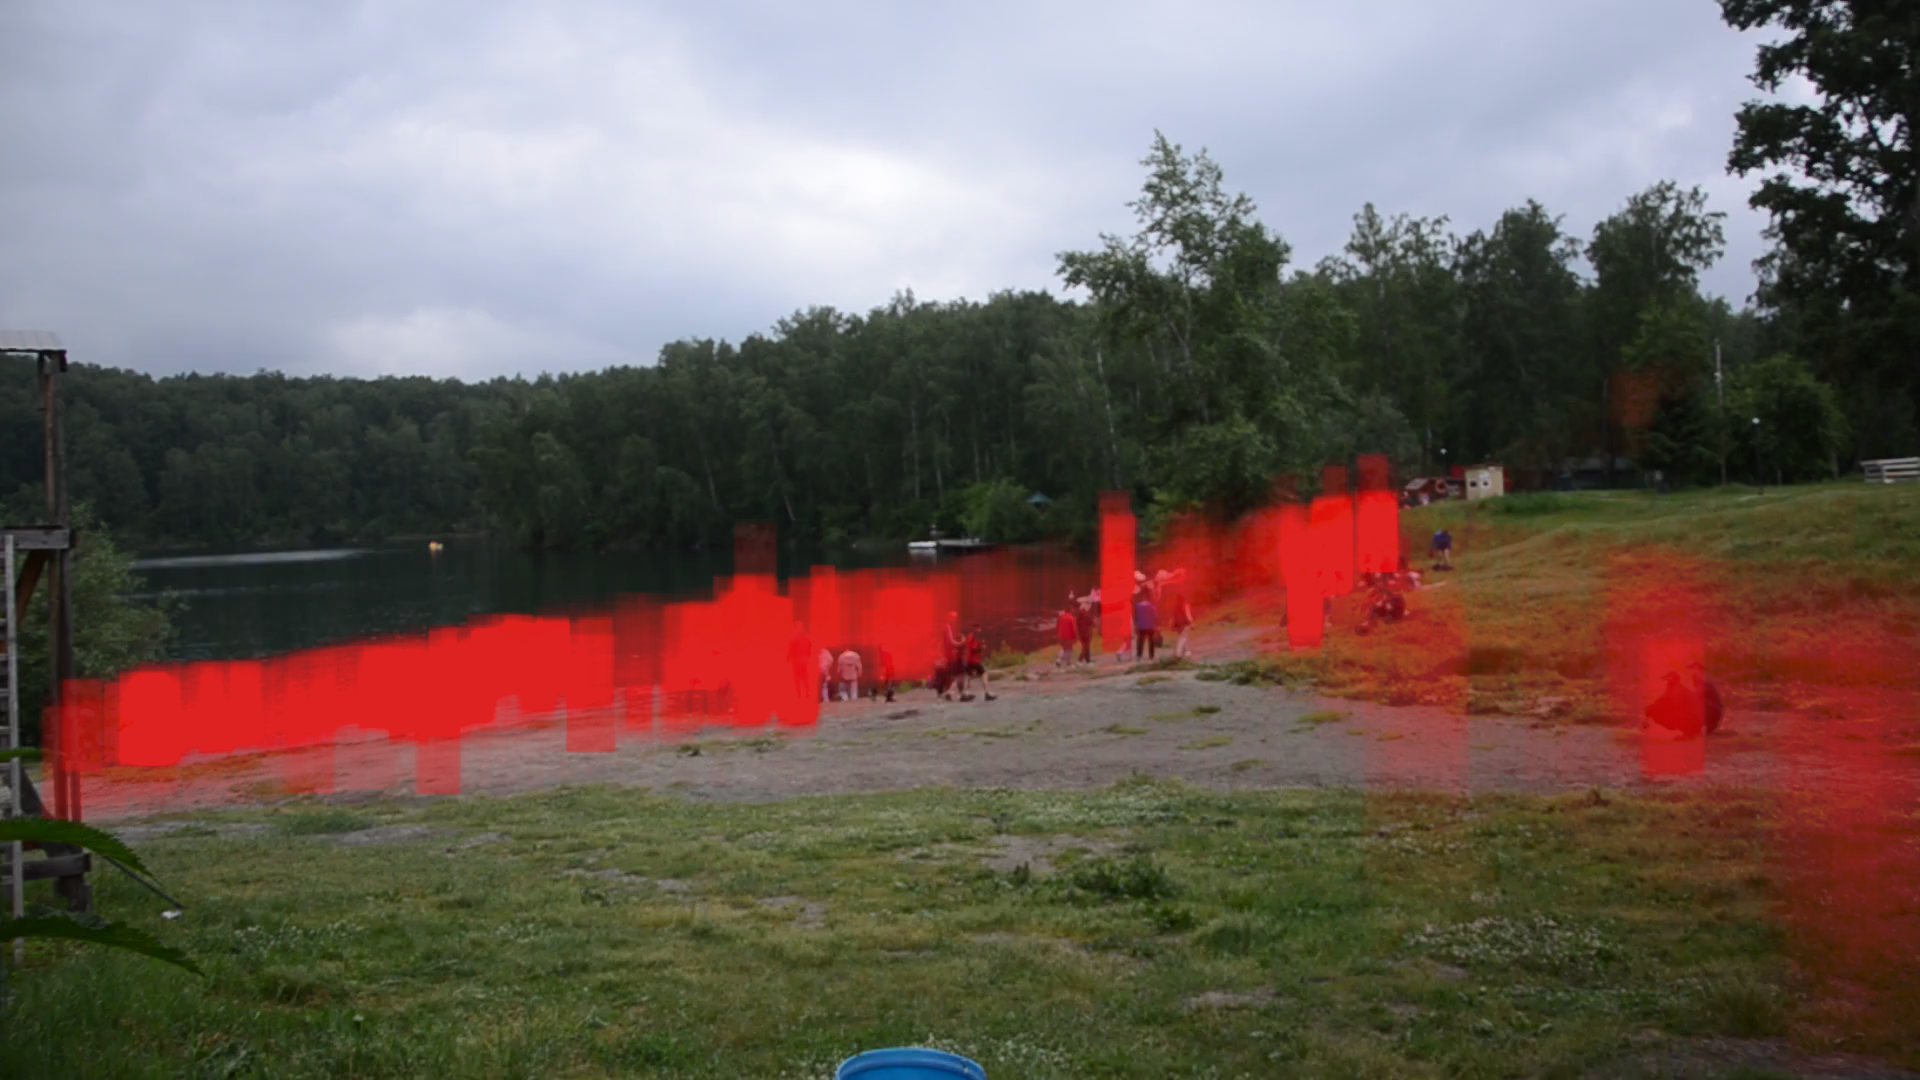

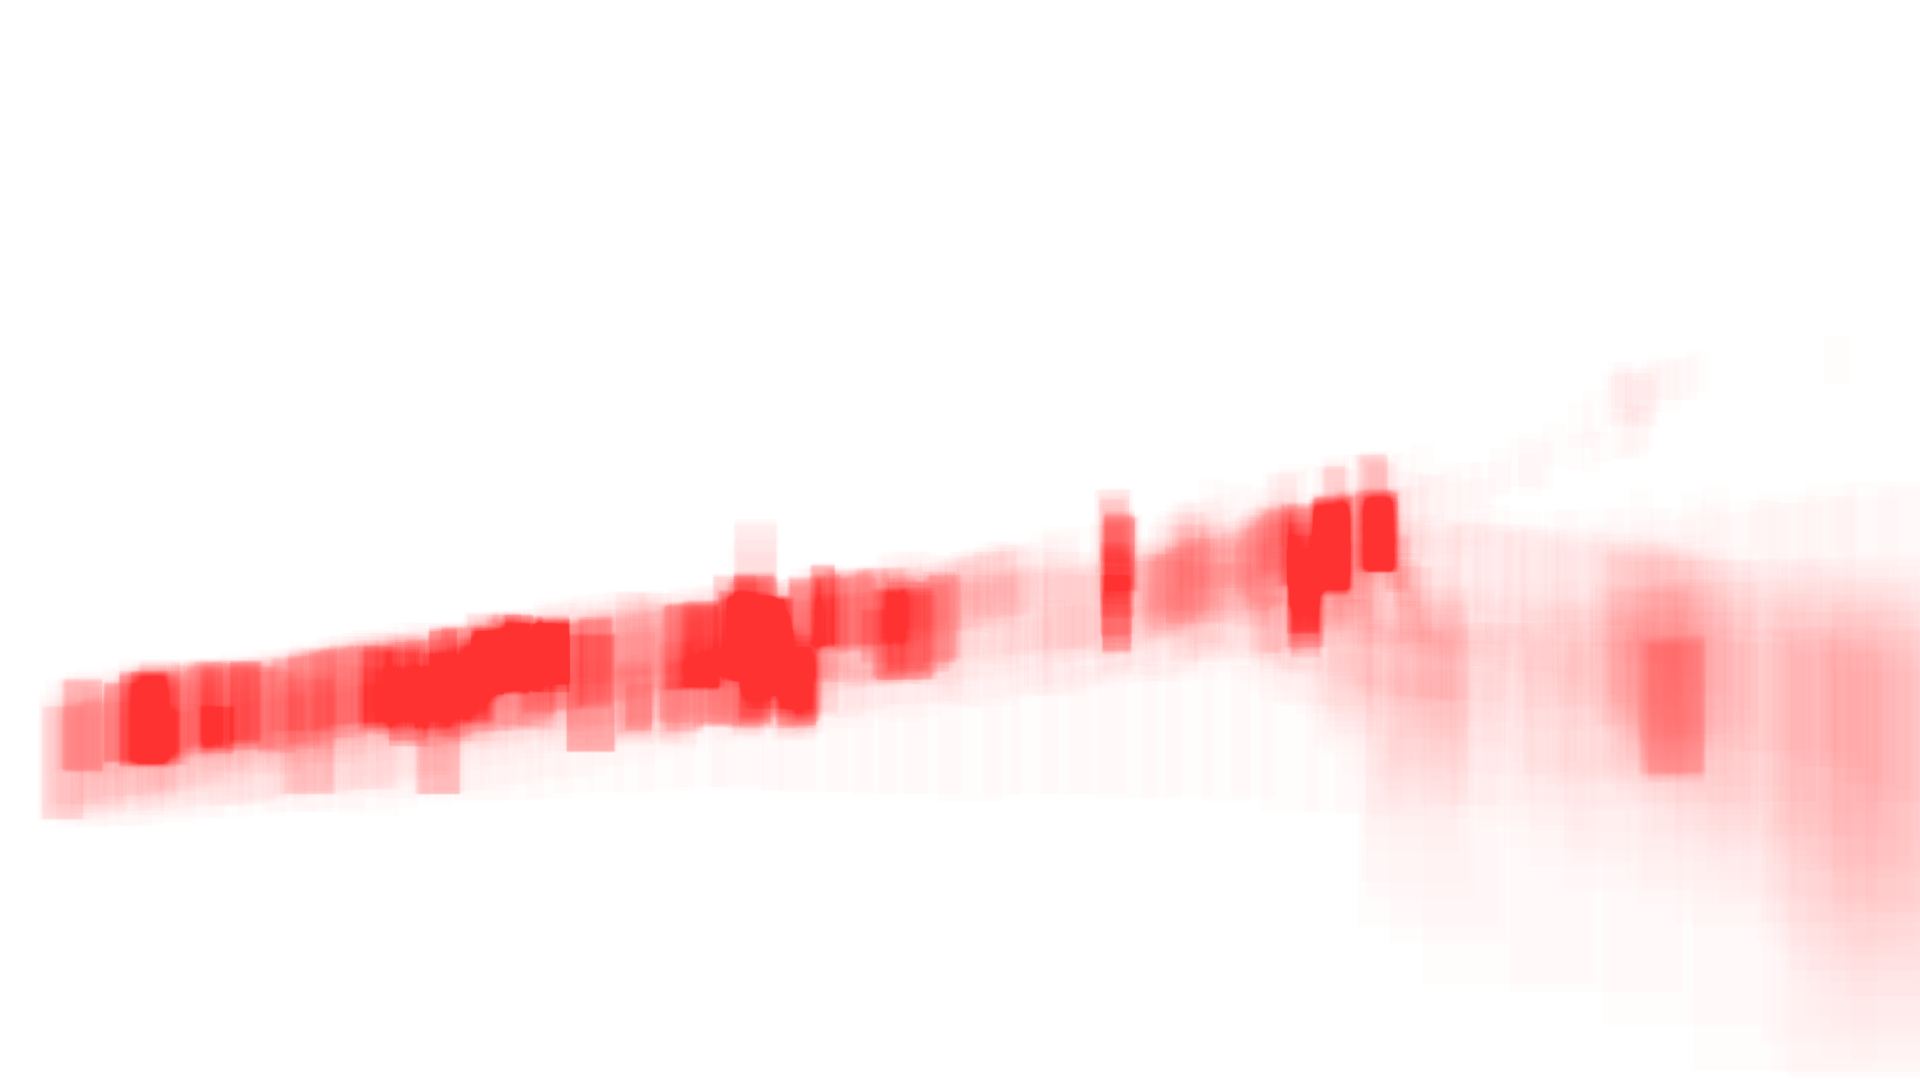

In [ ]:
result = detect('/content/drive/MyDrive/heatmap/source/DSC.mp4', (0, 0, 255,255), 125, 0, True)

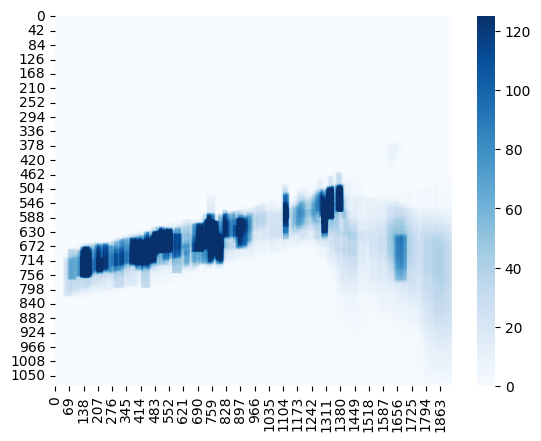

In [ ]:
plt.close()
#img1 = plt.imread("/content/drive/MyDrive/heatmap/source/нагорный/NO20230617-203407-022139F-results/result-white.png")
#cv2.resize(img1, [432, 288])
hm = sn.heatmap(result,cmap="Blues")

hm.figure.savefig('result-heatmap')